In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
import torch
import torch.nn.functional as F
import h5py
from tqdm import tqdm
import pandas as pd
import numpy as np
from skimage.transform import resize

import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import warnings
warnings.filterwarnings("ignore")

# Images
main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
import sys
import os
sys.path.append(main_path)
from data_manipulation.data import Data
from models.clustering.correlations import *
from models.clustering.data_processing import *
from IPython.display import clear_output
clear_output()
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Resolution and fold for the tile clustering and slide representations.
resolution     = 2.0
fold_number    = 4
groupby        = 'leiden_%s' % resolution

# Folder run.
dataset     = 'Meso'
additional_dataset = 'TCGA_MESO'
meta_folder     = '750K'
matching_field  = 'slides'


# Pickle files.
folds_pickle = '{}/files/pkl_{}_he_test_train_slides.pkl'.format(main_path, dataset)

# Tile representation files.
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, additional_dataset, additional_dataset)
figure_path = main_path + '/workflow/figures/HPC_figures/'
os.makedirs(figure_path, exist_ok=True)
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')

435 HPC: 11
55 HPC: 9


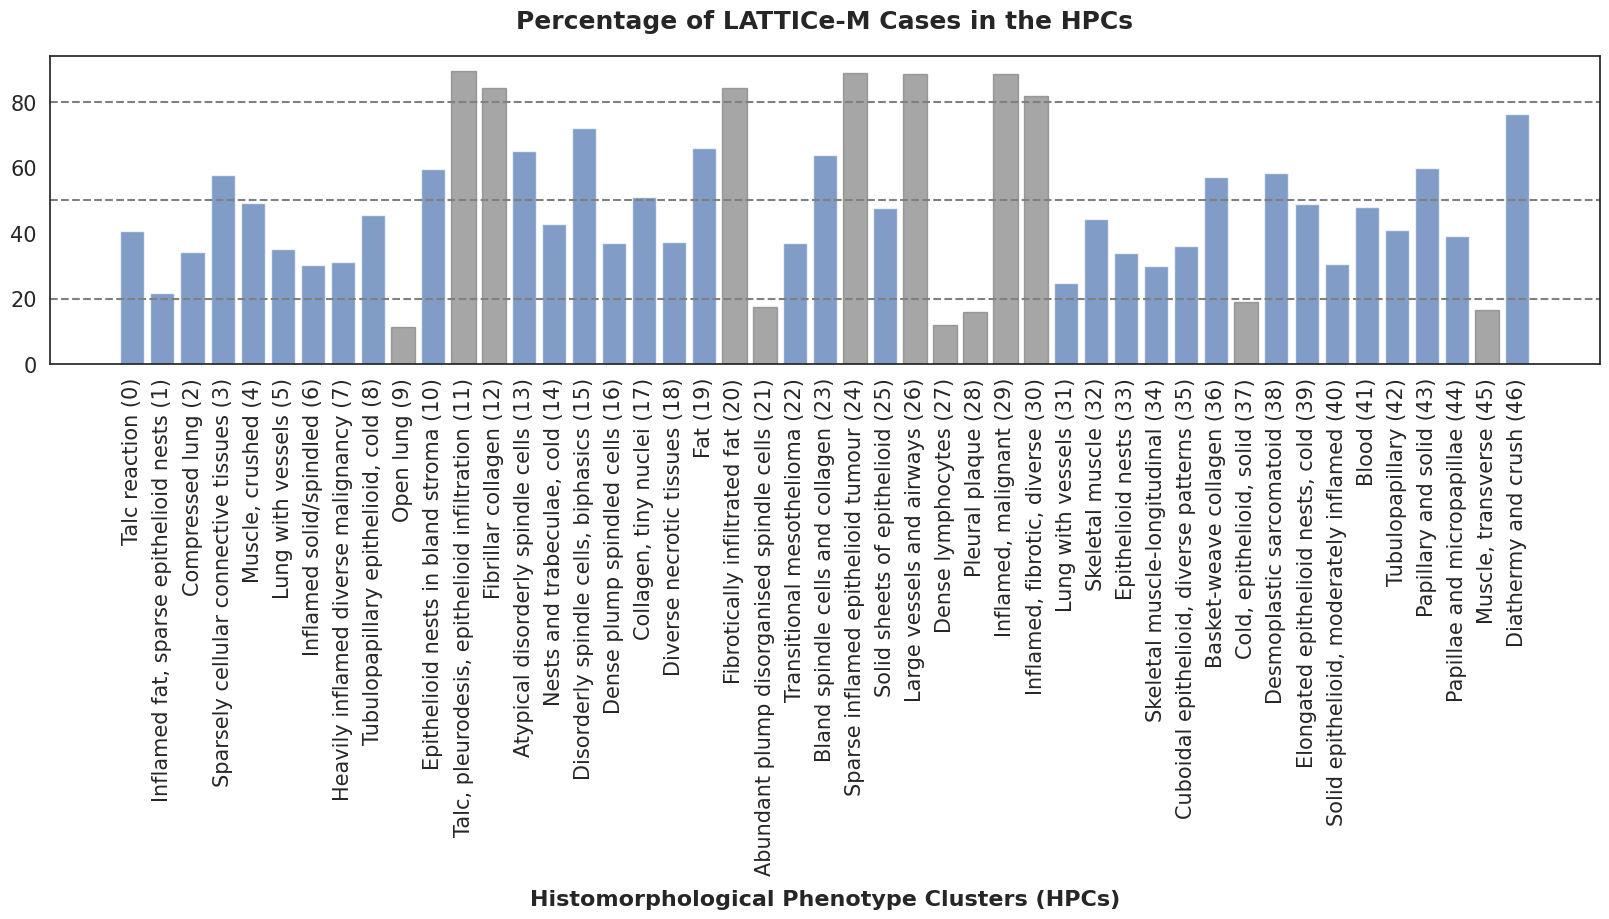

In [3]:
from skbio.stats.composition import clr_inv
meta_folder     = '750K'
df_train = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_train_metadata.csv'.format(main_path, 'Meso', meta_folder , '2p0', 4), index_col=0)
df_test = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_test_metadata.csv'.format(main_path, 'Meso', meta_folder , '2p0', 4), index_col=0)
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()


df_all = pd.concat([df_train, df_test])
leiden_clusters = [col for col in df_all.columns if col.isnumeric()]
inversed_df = pd.DataFrame(clr_inv(df_all[leiden_clusters]), columns=leiden_clusters)


sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(20,4))
hpc_df = inversed_df.copy()*100 
# at least 1% of case has the particular hpc: we call the patient HAS the HPC.
hpc_df = hpc_df > 1
hpc_df_percentages = hpc_df.astype(int).sum(axis=0)/hpc_df.shape[0]*100
# add hpc annotations to x labels
x_labels = []
for label in hpc_df_percentages.index.astype(int):
    text = annotations[annotations['HPC'] == label]['Summary'].values[0] + ' (' + str(label) + ')'
    x_labels.append(text)

ax.bar(x_labels, hpc_df_percentages.values, align='center')
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15);
ax.axhline(80, color='gray', linestyle='--')
ax.axhline(50, color='gray', linestyle='--')
ax.axhline(20, color='gray', linestyle='--')
ax.set_xlabel('Histomorphological Phenotype Clusters (HPCs)', fontsize=16, fontweight='bold', labelpad=10)
ax.set_title('Percentage of LATTICe-M Cases in the HPCs', fontsize=18, fontweight='bold', pad=20, loc='center')
for i, (v, bar) in enumerate(zip(hpc_df_percentages.values, ax.patches)):
    # if v == hpc_df_percentages.max():
    #     bar.set_alpha(1)
    if 20<v<80:
        bar.set_alpha(0.7)
    if v<20:
        # bar.set_alpha(0.3)
        bar.set_color('gray')
        bar.set_alpha(0.7)
    if v>80:
        bar.set_alpha(0.7)
        bar.set_color('gray')

print(hpc_df.sum().max(), 'HPC:', hpc_df.sum().idxmax())
print(hpc_df.sum().min(), 'HPC:', hpc_df.sum().idxmin())

plt.savefig('temp.pdf', bbox_inches='tight', dpi=500)

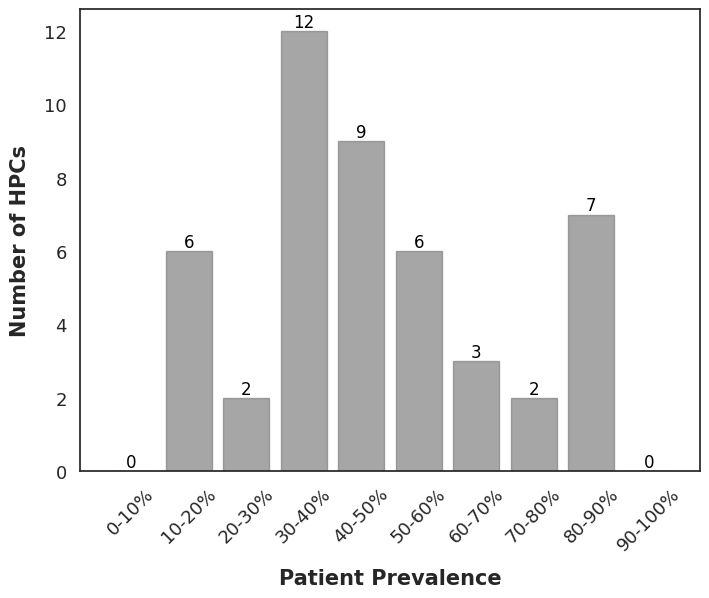

In [4]:
sns.set_theme(style="white")
# Bin the genes based on patient percentage
# binned = pd.cut(hpc_df_percentages, bins=[0, 20, 40, 60, 80, 100], labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest=True)
binned = pd.cut(hpc_df_percentages, bins=[0, 10,20,30, 40,50, 60,70, 80,90, 100], labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'], include_lowest=True)
binned_counts = binned.value_counts().sort_index()
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(binned_counts.index, binned_counts.values, align='center', color='gray', alpha=0.7)
plt.xticks(fontsize=13, rotation=45);
plt.yticks(fontsize=13);
# ax.set_xlabel('Percentage of HPCs per patient', fontsize=16, fontweight='bold', labelpad=10)
ax.set_xlabel('Patient Prevalence', fontsize=15, fontweight='bold', labelpad=10)
# ax.set_title('Number of HPCs grouped by their percentages', fontsize=18, fontweight='bold', pad=20, loc='center')
ax.set_ylabel('Number of HPCs', fontsize=15, fontweight='bold', labelpad=10)
# ax.axhline(10, color='gray', linestyle='--')
# add the number on top of the bars
for i, (v, bar) in enumerate(zip(binned_counts.values, ax.patches)):
    bar.set_alpha(0.7)
    bar.set_color('gray')
    ax.annotate(str(v), (bar.get_x() + bar.get_width() / 2, v), ha='center', va='bottom', fontsize=12, color='black')
# ax.set_title('Percentage of LATTICe-M Cases in the HPCs', fontsize=18, fontweight='bold', pad=20, loc='center')

plt.savefig('temp_percentage2.pdf',  bbox_inches='tight', dpi=500)


Text(0.5, 1.0, 'Number of patients with a HPC percentage > 50%')

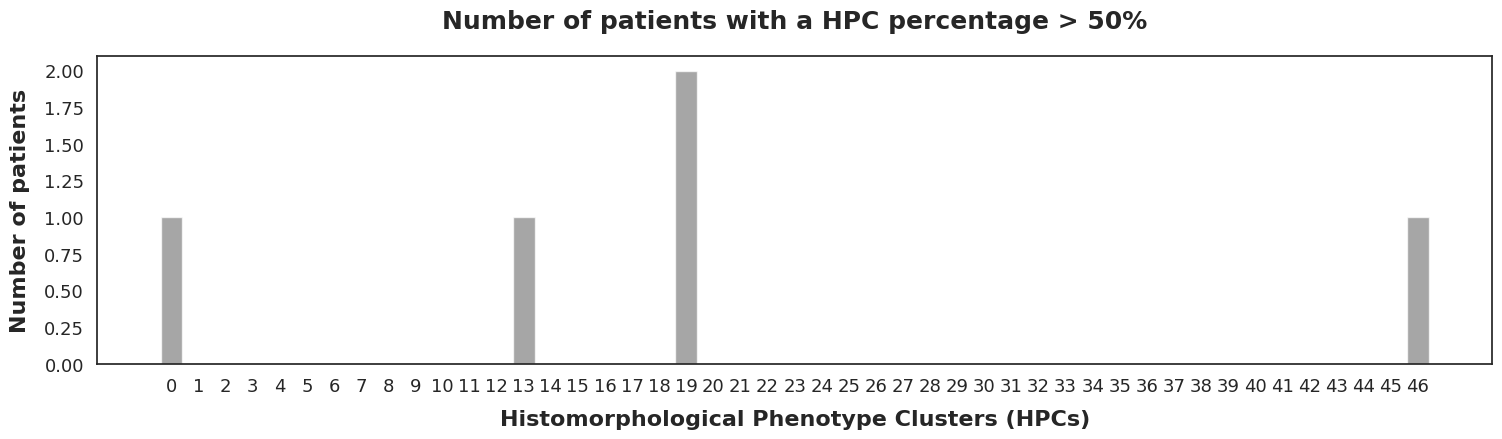

In [105]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(18,4))
threshold = 50
hpc_df = inversed_df.copy()*100
temp = (hpc_df > threshold).sum(axis=0).astype(int)
ax.bar(temp.index, temp.values, align='center', color='gray', alpha=0.7)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);
ax.set_xlabel('Histomorphological Phenotype Clusters (HPCs)', fontsize=16, fontweight='bold', labelpad=10)
ax.set_ylabel('Number of patients', fontsize=16, fontweight='bold', labelpad=10)

ax.set_title('Number of patients with a HPC percentage > {}%'.format(threshold), fontsize=18, fontweight='bold', pad=20, loc='center')


#### Path-Annotation Agreement

In [1]:
import pandas as pd
import numpy as np

def clean_elements(x):
    xp = []
    for i in x:
        if not isinstance(i, float): 
            xp.append(i)
            xp = [x.strip() for x in xp]
    return xp


main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
figure_path = main_path + '/workflow/figures/HPC_figures/'
df1 = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_CR.xlsx', sheet_name='Sheet1', header=50, usecols='B:Y')
df1.iloc[-1, 0] = 46
df1.columns = [x+'_1' for x in df1.columns]
df1.rename(columns={'Cluster_1': 'HPC'}, inplace=True)

df2 = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_JLQ.xlsx', sheet_name='Sheet1', header=50, usecols='B:Y')
df2.columns = [x+'_2' for x in df2.columns]
df2.rename(columns={'Cluster_2': 'HPC'}, inplace=True)

df3 = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_SK.xlsx', sheet_name='Sheet1', header=50, usecols='B:Y')
df3.columns = [x+'_3' for x in df3.columns]
df3.rename(columns={'Cluster_3': 'HPC'}, inplace=True)

df_total = pd.merge(df1, df2, on='HPC', how='inner')
df_total = pd.merge(df_total, df3, on='HPC', how='inner')
df_total = df_total.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)

In [2]:
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
import dataframe_image as dfi
from scipy.stats import norm


def p_z_fscores(table):
    kappa = fleiss_kappa(table)


    N, k = table.shape
    n = np.sum(table[0])  # assumes fixed number of raters per item
    p_j = np.sum(table, axis=0) / (N * n)

    Pe_bar = np.sum(p_j ** 2)
    # print('expected agreement by chance:', Pe_bar)
    Pj3 = np.sum(p_j ** 3)
    # print('expected agreement by chance (k=3):', Pj3)

    var_kappa = (2 * (k - 1)) / (N * n * (n - 1)) * (Pe_bar - Pj3)

    # Step 4: z-score and p-value
    z = kappa / np.sqrt(var_kappa)
    p_value = 2 * (1 - norm.cdf(abs(z)))
    # get in the format of '.2f' in case of e-n power, write it
    p_value, z, kappa = f'{p_value:.2e}', f'{z:.2f}', f'{kappa:.2f}'
    return kappa, z, p_value

# inf_di = DefaultDict({'None-sparse':1, 'Mild-moderate':2, 'Marked':3})
# nec_di = DefaultDict({'None':1, 'Some':2, 'Universal':3})
# strm_cl_di = DefaultDict({'Low':1, 'Moderate':2, 'High':3})
# epi_grwth_pttr_di = DefaultDict({'Tubular':1, 'Solid':3, 'Micropapillary':2, 'Adenomaotoid':5, 'Papillary':4, 'Trabecular':6})
# spindle_arch_di = DefaultDict({'Orderly (parallel)':1, 'Less orderly (eg wavy)':2, 'Disorderly (random/storiform)':3})
# spindle_cel_di = DefaultDict({'Low':1, 'Medium':2, 'High':3})
# desmoplastic_di = DefaultDict({'Absent':1, 'Present':2})
# nucl_attypia_di = DefaultDict({'None/mild':1, 'Moderate':2, 'Severe':3})
# clust_purity_di = DefaultDict({'Low (< 50%)':1, 'Moderate (50 - 75%)':2, 'High (> 75%)':3})



kappa_value_dic, pval_dict, z_dict = dict(), dict(), dict()

# Infllamation degree.
Inflammation = df_total[['Inflammation*_1', 'Inflammation*.1_1', 'Inflammation*.2_1', 'Inflammation*_2', 'Inflammation*.1_2', 'Inflammation*.2_2', 'Inflammation*_3', 'Inflammation*.1_3', 'Inflammation*.2_3' ]]
temp = pd.DataFrame([clean_elements(x) for x in Inflammation.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'None-sparse':1, 'Mild-moderate':2, 'Marked':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Inflammation'], z_dict['Inflammation'], pval_dict['Inflammation'] = p_z_fscores(table)


# Necrosis degree.
Necrosis = df_total[['Necrosis**_1', 'Necrosis**.1_1', 'Necrosis**.2_1', 'Necrosis**_2', 'Necrosis**.1_2', 'Necrosis**.2_2', 'Necrosis**_3', 'Necrosis**.1_3', 'Necrosis**.2_3' ]]
for i in range(len(Necrosis)):
    for j in range(len(Necrosis.iloc[i])):
        if isinstance(Necrosis.iloc[i][j], str):
            Necrosis.iloc[i][j] = Necrosis.iloc[i][j].strip()
temp = pd.DataFrame([clean_elements(x) for x in Necrosis.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'None':1, 'Some':2, 'Universal':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Necrosis'], z_dict['Necrosis'], pval_dict['Necrosis'] = p_z_fscores(table)

Nuclear_atypia = df_total[['Nuclear atypia_1', 'Nuclear atypia.1_1', 'Nuclear atypia_2', 'Nuclear atypia.1_2', 'Nuclear atypia_3', 'Nuclear atypia.1_3']]
temp = pd.DataFrame([clean_elements(x) for x in Nuclear_atypia.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'None/mild':1, 'Moderate':2, 'Severe':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Nuclear Atypia'], z_dict['Nuclear Atypia'], pval_dict['Nuclear Atypia'] = p_z_fscores(table)


# Percentage cluster purity
cluster_purity = df_total[['Percentage cluster purity_1', 'Percentage cluster purity_2', 'Percentage cluster purity_3']]
temp = pd.DataFrame([clean_elements(x) for x in cluster_purity.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Low (< 50%)':1, 'Moderate (50 - 75%)':2, 'High (> 75%)':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Cluster Purity'], z_dict['Cluster Purity'], pval_dict['Cluster Purity'] = p_z_fscores(table)

# Stromal cellularity degree.
Stromal_cellularity = df_total[['Stromal cellularity***_1', 'Stromal cellularity***_2', 'Stromal cellularity***_3']]
temp = pd.DataFrame([clean_elements(x) for x in Stromal_cellularity.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Low':1, 'Moderate':2, 'High':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Stromal Cellularity'], z_dict['Stromal Cellularity'], pval_dict['Stromal Cellularity'] = p_z_fscores(table)


# epith_growth_pattern.
epith_growth_pattern = df_total[['Predominant architectural growth pattern_1', 'Second most predominant pattern_1', 'Predominant architectural growth pattern_2', 'Second most predominant pattern_2', 'Predominant architectural growth pattern_3', 'Second most predominant pattern_3']]
temp = pd.DataFrame([clean_elements(x) for x in epith_growth_pattern.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Tubular':1, 'Solid':3, 'Micropapillary':2, 'Adenomaotoid':5, 'Papillary':4, 'Trabecular':6, 'Trabecualr':6}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Growth Pattern'], z_dict['Growth Pattern'], pval_dict['Growth Pattern'] = p_z_fscores(table)

# spindle tiles architecture.
spindle_arch = df_total[['Architecture_1', 'Architecture_2', 'Architecture_3']]
temp = pd.DataFrame([clean_elements(x) for x in spindle_arch.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Orderly (parallel)':1, 'Less orderly (eg wavy)':2, 'Disorderly (random/storiform)':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Spindle Architecture'], z_dict['Spindle Architecture'], pval_dict['Spindle Architecture'] = p_z_fscores(table)

spidle_cellularity = df_total[['Cellularity_1', 'Cellularity_2', 'Cellularity_3']]
temp = pd.DataFrame([clean_elements(x) for x in spidle_cellularity.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Low':1, 'Medium':2, 'High':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Spindle Cellularity'], z_dict['Spindle Cellularity'], pval_dict['Spindle Cellularity'] = p_z_fscores(table)


desmoplastic_component = df_total[['Desmoplastic_1', 'Desmoplastic_2', 'Desmoplastic_3']]
temp = pd.DataFrame([clean_elements(x) for x in desmoplastic_component.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Absent':1, 'Present':2}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Desmoplastic Component'], z_dict['Desmoplastic Component'], pval_dict['Desmoplastic Component'] = p_z_fscores(table)

kappa_value_dic, pval_dict, z_dict


({'Inflammation': '0.32',
  'Necrosis': '0.29',
  'Nuclear Atypia': '0.40',
  'Cluster Purity': '0.23',
  'Stromal Cellularity': '0.56',
  'Growth Pattern': '0.44',
  'Spindle Architecture': '0.42',
  'Spindle Cellularity': '0.40',
  'Desmoplastic Component': '0.53'},
 {'Inflammation': '5.27e-07',
  'Necrosis': '1.44e-07',
  'Nuclear Atypia': '9.70e-10',
  'Cluster Purity': '1.31e-05',
  'Stromal Cellularity': '0.00e+00',
  'Growth Pattern': '0.00e+00',
  'Spindle Architecture': '6.88e-13',
  'Spindle Cellularity': '2.90e-12',
  'Desmoplastic Component': '0.00e+00'},
 {'Inflammation': '5.02',
  'Necrosis': '5.26',
  'Nuclear Atypia': '6.11',
  'Cluster Purity': '4.36',
  'Stromal Cellularity': '8.67',
  'Growth Pattern': '11.62',
  'Spindle Architecture': '7.18',
  'Spindle Cellularity': '6.98',
  'Desmoplastic Component': '10.88'})

In [3]:
def clean_array(x):
    xp = []
    for i in x:
        if not isinstance(i, float): 
            xp.append(i)
            xp = [x.strip() for x in xp]
    if len(xp) == 1:
        xp = xp[0]
    return xp

def add_star(temp_data, col_name, col_name_old, counts_table, keep_old=False):
    temp_data[col_name] = temp_data[col_name_old].copy()
    for idx in temp_data.index:
        x = temp_data.loc[idx, col_name_old]
        if isinstance(x, list):
            if len(x) == 0:
                temp_data.loc[idx, col_name] = ''
            else:
                if keep_old:temp_data.loc[idx, col_name] = ' | '.join(x)
                else: temp_data.loc[idx, col_name] = ''
        elif isinstance(x, str):
            count = counts_table.loc[idx, x]
            if count >= 3:
                if keep_old: temp_data.loc[idx, col_name] = x + '(*)'
                else: temp_data.loc[idx, col_name] = '*'
            else:
                if keep_old: temp_data.loc[idx, col_name] = x
                else: temp_data.loc[idx, col_name] = ''
        else:
            if keep_old: temp_data.loc[idx, col_name] = x
            else: temp_data.loc[idx, col_name] = ''
    return temp_data

def inflammation_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Marked':
            color = 'background-color: #990001'
        elif x == 'Mild-moderate':
            color = 'background-color: #e06666'
        elif x == 'None-sparse':
            color = 'background-color: #f5cbcc'
    else:
        color = 'background-color: #666666'
    
    return [color] * len(val)


def necrosis_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'None':
            color = 'background-color: #f8e8e9'
        elif x == 'Some':
            color = 'background-color: #e06666'
        elif x == 'Universal':
            color = 'background-color: #660000'
    else:
        color = 'background-color: #666666'
    
    return [color] * len(val)

def nuclear_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'None/mild':
            color = 'background-color: #ead1db'
        elif x == 'Moderate':
            color = 'background-color: #c27ba0'
        elif x == 'Severe':
            color = 'background-color: #751a47'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def purity_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Low (< 50%)':
            color = 'background-color: #ea9999'
        elif x == 'Moderate (50 - 75%)':
            color = 'background-color: #ffd966'
        elif x == 'High (> 75%)':
            color = 'background-color: #93c47d'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def stromal_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Low':
            color = 'background-color: #d0e2f3'
        elif x == 'Moderate':
            color = 'background-color: #3d85c6'
        elif x == 'High':
            color = 'background-color: #073763'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def spindle_cel_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Low':
            color = 'background-color: #ead1db'
        elif x == 'Medium':
            color = 'background-color: #c27ba0'
        elif x == 'High':
            color = 'background-color: #751a47'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def desmoplastic_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Absent':
            color = 'background-color: #b5d7a8'
        elif x == 'Present':
            color = 'background-color: #e06666'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''

    return [color] * len(val)


def epith_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Tubular':
            color = 'background-color: #647d93'
        elif x == 'Solid':
            color = 'background-color: #b4a7d5'
        elif x == 'Papillary':
            color = 'background-color: #f9cb9c'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def spindle_arch_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Orderly (parallel)':
            color = 'background-color: #d9ead3'
        elif x == 'Less orderly (eg wavy)':
            color = 'background-color: #f6bc1e'
        elif x == 'Disorderly (random/storiform)':
            color = 'background-color: #b6d7a8'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

In [4]:
col_old_names = ['Inf']
temp_data = Inflammation.copy()
df = pd.DataFrame(temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1), columns=col_old_names)
df = add_star(df, 'Inflammation', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))


col_old_names.append('nec')
temp_data = Necrosis.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Necrosis', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('nuc_atypia')
temp_data = Nuclear_atypia.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Nuclear Atypia', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('purity')
temp_data = cluster_purity.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Cluster Purity', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('strm_cl')
temp_data = Stromal_cellularity.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Stromal Cellularity', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('spindle_cel')
temp_data = spidle_cellularity.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Spindle Cellularity', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('desmoplastic')
temp_data = desmoplastic_component.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Desmoplastic Component', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('epith_growth')
temp_data = epith_growth_pattern.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Growth Pattern', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0), keep_old=True)

col_old_names.append('spindle_arch')
temp_data = spindle_arch.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)

df = add_star(df, 'Spindle Architecture', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0), keep_old=True)


temp_col = ['Inf', 'Inflammation', 'nec', 'Necrosis', 'nuc_atypia',
       'Nuclear Atypia', 'purity', 'Cluster Purity', 'strm_cl',
       'Stromal Cellularity', 'spindle_cel', 'Spindle Cellularity',
       'desmoplastic', 'Desmoplastic Component', 'epith_growth',
       'Growth Pattern', 'spindle_arch', 'Spindle Architecture']
kappa_df = pd.DataFrame(columns=temp_col)
for key, value in kappa_value_dic.items():
    kappa_df.loc[0,key] = value
kappa_df.fillna(0, inplace=True)
kappa_df.index = ["Fleiss' kappa"]
# display(kappa_df)
df = pd.concat([df, kappa_df], axis=0)
wider_cols_1 = {
    'selector': 'td:nth-last-child(1)', 
    'props': 'min-width:800px;'}

wider_cols_2 = {
    'selector': 'td:nth-last-child(2)', 
    'props': 'min-width:400px;'}


headers = {
 'selector': 'th.col_heading',
 'props': [
                ('height', '130px'),
                ('white-space', 'normal'),
                ('word-wrap', 'break-word'),
                ('text-align', 'center'),
                ('border', '2px solid black'),
                ('font-size','25pt')
            ]
}
index_style = {
 'selector': 'th.row_heading',
 'props': 'font-size:25pt'
}


# Style the display column but show the modified content
styled_df = df.style\
    .set_properties(**{'color': 'black', 'text-align':'center','border': '1px solid black','font-size':'23pt' } )\
    .apply(inflammation_color, col_name='Inf', axis=1, subset=['Inflammation', 'Inf'])\
    .apply(necrosis_color, col_name='nec', axis=1, subset=['Necrosis', 'nec'])\
    .apply(nuclear_color, col_name='nuc_atypia', axis=1, subset=['Nuclear Atypia', 'nuc_atypia'])\
    .apply(purity_color, col_name='purity', axis=1, subset=['Cluster Purity', 'purity'])\
    .apply(stromal_color, col_name='strm_cl', axis=1, subset=['Stromal Cellularity', 'strm_cl'])\
    .apply(spindle_cel_color, col_name='spindle_cel', axis=1, subset=['Spindle Cellularity', 'spindle_cel'])\
    .apply(desmoplastic_color, col_name='desmoplastic', axis=1, subset=['Desmoplastic Component', 'desmoplastic'])\
    .apply(spindle_arch_color, col_name='spindle_arch', axis=1, subset=['Spindle Architecture', 'spindle_arch'])\
    .apply(epith_color, col_name='epith_growth', axis=1, subset=['Growth Pattern', 'epith_growth'])\
    .apply(lambda _: ['background-color: lightblue' for _ in range(len(df.columns))], 
           axis=1, subset=pd.IndexSlice["Fleiss' kappa", :])\
    .set_table_styles([headers, index_style, wider_cols_1, wider_cols_2])\
    
           
    





styled_df.hide(col_old_names, axis=1)

# kappa_df = pd.DataFrame(columns=styled_df.columns)
# for key, value in kappa_value_dic.items():
#     kappa_df.loc[0,key] = value
# kappa_df.fillna(0, inplace=True)
# kappa_df.index = ["Fleiss' kappa"]
# index_style = {
#  'selector': 'th.row_heading',
#  'props': 'font-size:22px'
# }
# styled_kappa = kappa_df.style\
#     .set_properties(**{'color': 'black', 'font-weight': 'bold', 'text-align':'center', 'background-color':'lightblue','border': '1px solid black', 'border-top': '4px solid black','font-size':'22px' } )\
#     .set_table_styles([index_style])
    # .set_table_styles([
    #     {'selector': 'th.row_heading', 'props': [('text-align', 'center'), ('font-size','22px')]},
    # ])\

# display(styled_kappa)


# styled_df.concat(styled_kappa)
# styled_df = styled_df.set_table_styles([index_style])

# styled_df.concat(styled_z_val)
# styled_df.concat(styled_pval)
# bigger font size for everything
# styled_df.set_table_styles([{'selector': 'td', 'props': [('font-size', '20px')]}], axis=0)\
# styled_df
dfi.export(styled_df, 'figures/HPC_figures/styled_dataframe.pdf', table_conversion='selenium', dpi=300)


In [6]:
styled_df

,Inflammation,Necrosis,Nuclear Atypia,Cluster Purity,Stromal Cellularity,Spindle Cellularity,Desmoplastic Component,Growth Pattern,Spindle Architecture
0,,*,,*,,,,,Disorderly (random/storiform)
1,*,*,,*,,,,,
2,*,*,,*,,,,,
3,*,*,,,,,,,Orderly (parallel)
4,*,*,,*,,,,,
5,*,*,,*,,,,,
6,,,*,,,,,Solid | Trabecular,
7,,,,,,,,Solid,Disorderly (random/storiform)
8,*,,*,,*,,,Tubular(*),
9,*,*,,*,,,,,


In [5]:
styled_df.to_excel('/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/workflow/sup_data/fig2/path_annotation_table.xlsx', index=True, engine='openpyxl')

In [5]:
dict_colours = dict()
dict_colours['Inflammation'] = dict({'None-sparse': '#f5cbcc', 'Mild-moderate': '#e06666', 'Marked': '#990001'})
dict_colours['Necrosis'] = dict({'None': '#f8e8e9', 'Some': '#e06666', 'Universal': '#660000'})
dict_colours['Nuclear Atypia'] = dict({'None/mild': '#ead1db', 'Moderate': '#c27ba0', 'Severe': '#751a47'})
dict_colours['Cluster Purity'] = dict({'Low (< 50%)': '#ea9999', 'Moderate (50 - 75%)': '#ffd966', 'High (> 75%)': '#93c47d'})
dict_colours['Stromal Cellularity'] = dict({'Low': '#d0e2f3', 'Moderate': '#3d85c6', 'High': '#073763'})
dict_colours['Spindle Cellularity'] = dict({'Low': '#ead1db', 'Medium': '#c27ba0', 'High': '#751a47'})
dict_colours['Desmoplastic Component'] = dict({'Absent': '#b5d7a8', 'Present': '#e06666'})
dict_colours['Growth Pattern'] = dict({'Tubular': '#647d93', 'Solid': '#b4a7d5', 'Papillary': '#f9cb9c'})
dict_colours['Spindle Architecture'] = dict({'Orderly (parallel)': '#d9ead3', 'Less orderly (eg wavy)': '#f6bc1e', 'Disorderly (random/storiform)': '#b6d7a8'})

def style_legend(df):
    styles = [
        {'selector': 'th', 'props': [('color', 'black'), ('text-align', 'center')]},
        {'selector': 'th.col_heading', 'props': [('color', 'black'), ('text-align', 'center'), ('border', '2px solid black')]},
        {'selector': 'th', 'props': [('width', '130px')]}
    ]
    # take the colur from defined function previously
    def apply_color(val, col_name):
        if isinstance(val, str):
            color = dict_colours.get(col_name).get(val)
            return f'background-color: {color}'
        else:
            return ''

    col_name = df.columns[0]
    return (df.style
            .applymap(apply_color, col_name=col_name, subset=[col_name])
            .set_properties(**{
                'text-align': 'center',
                # 'font-weight': 'bold',
                'padding': '10px',
                'border': '1px solid black',
                'color': 'black',
            })
            .set_table_styles(styles).hide()
           )


legend_data = pd.DataFrame({
    'Cluster Purity': ['High (> 75%)', 'Moderate (50 - 75%)', 'Low (< 50%)'],
    # 'Inflammation': ['Marked', 'Mild-moderate', 'None-sparse'],
    # 'Necrosis': ['Universal', 'Some', 'None'],
    # 'Nuclear Atypia': ['Severe', 'Moderate', 'None/mild'],
    # 'Stromal Cellularity': ['High', 'Moderate', 'Low'],
})
styled_legend = style_legend(legend_data)
styled_legend
dfi.export(styled_legend, 'figures/HPC_figures/legend.png', table_conversion='selenium')

### MIL Based Model

In [54]:
class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        self.data = np.load(data_path, allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        instance = torch.from_numpy(self.data[idx][0])
        label = torch.tensor(self.data[idx][1], dtype=torch.float32)
        slide = self.data[idx][2]

        return instance, label, slide

In [33]:
def get_scores_simple(labels, y_prob):
    scores = dict()
    labels = np.array(labels)
    y_prob = np.array(y_prob)
    scores['ROC AUC'] = roc_auc_score(y_true=list(labels), y_score=list(y_prob))
    scores['Avg. Precision'] = average_precision_score(y_true=list(labels), y_score=list(y_prob))
    tn, fp, fn, tp = confusion_matrix(labels, (y_prob>0.5)*1.0).ravel()
    scores['Sensitivity'] = tp / (tp+fn)
    scores['Specificity'] = tn / (tn+fp)
    scores['Accuracy'] = accuracy_score(labels, (y_prob>0.5)*1.0)
    return scores

class CsvBags(torch.utils.data.Dataset):
    def __init__(self, csv):
        self.csv = csv
        self.bags, self.labels = self._create_bag()

    def __len__(self):
        return len(self.bags)

    def _create_bag(self):
        bag_list = []
        label_list = []
        for bag in self.csv['slides'].unique():

            bag_df = self.csv[self.csv['slides']==bag]
            bag_list.append(torch.from_numpy(bag_df.drop(['slides', 'Meso_type'], axis=1).values).unsqueeze(1))
            # TODO: just get one label for the bag
            label_list.append(torch.from_numpy(bag_df['Meso_type'].values))
        return bag_list, label_list

    def __getitem__(self, idx):
        return self.bags[idx], self.labels[idx]
    
    def get_slide_bag(self, slide):
        bag_df = self.csv[self.csv['slides']==slide]
        bag = torch.from_numpy(bag_df.drop(['slides', 'Meso_type'], axis=1).values).unsqueeze(1)
        label = torch.from_numpy(bag_df['Meso_type'].values)
        return bag, label
    
def make_weighted_loder(data):
    from torch.utils.data import WeightedRandomSampler
    all_labels = torch.tensor([t[0].item() for t in CsvBags(data).labels], dtype=torch.long)
    class_counts = torch.bincount(all_labels)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[all_labels]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    loader = torch.utils.data.DataLoader(CsvBags(data), batch_size=1, sampler=sampler)
    return loader

In [14]:
dataset = 'Meso'
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
frame, dims, rest = representations_to_frame(h5_complete_path, meta_field='Meso_type', rep_key='z_latent')


additional_dataset = 'TCGA_MESO'
h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, additional_dataset, additional_dataset)
frame_additional, dims_additional, rest_additional = representations_to_frame(h5_additional_path, meta_field='Meso_type', rep_key='z_latent')

Loading representations: /mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/hdf5_Meso_he_complete_filtered_metadata.h5
Keys: <KeysViewHDF5 ['HB_score', 'Meso_type', 'N_stage', 'Sex', 'TNM_Stage', 'T_Stage', 'age', 'case_Id', 'chest_wall_involvement', 'confident_diagnosis', 'desmoplastic_component', 'diaphragm_involvement', 'haemoglobin', 'hist_subtype', 'img_h_latent', 'img_z_latent', 'indexes', 'labels', 'lung_involvement', 'original_set', 'os_event_data', 'os_event_ind', 'patterns', 'recurrence', 'rib_involvement', 'samples', 'side', 'slides', 'smoking_history', 'tiles', 'time_to_recurrence', 'type', 'wcc_score']>
Loading representations: /mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/TCGA_MESO/h224_w224_n3_zdim128/hdf5_TCGA_MESO_he_complete_filtered_metadata.h5
Keys: <KeysViewHDF5 ['Meso_type', 'age_at_diagnosis', 'age_at_index', 'ajcc_patho

In [6]:
# Data packing for MIL (Just one fold)
csv_data = frame.iloc[:,0:128]
csv_data['Meso_type'] = frame['Meso_type'].astype(float)
csv_data['slides'] = frame['slides']
ratio = 0.8
train_df_slides = np.random.choice(csv_data['slides'].unique(), size=int(len(csv_data['slides'].unique())*ratio), replace=False)
test_df_slides = list(set(csv_data['slides'].unique()) - set(train_df_slides))
train_df = csv_data[csv_data['slides'].isin(train_df_slides)]
test_df = csv_data[csv_data['slides'].isin(test_df_slides)]
print(f'SIZE: Train slides: {len(train_df_slides)} - Test slides: {len(test_df_slides)}', f'| Train samples: {len(train_df)} - Test samples: {len(test_df)}')


csv_data_additional = frame_additional.iloc[:,0:128]
csv_data_additional['Meso_type'] = frame_additional['type']
csv_data_additional['Meso_type'] = csv_data_additional['Meso_type'].replace({'Epithelioid': 0, 'Sarcomatoid': 1, 'Biphasic': 1}).astype(float)
csv_data_additional['slides'] = frame_additional['slides']

SIZE: Train slides: 2756 - Test slides: 690 | Train samples: 2582930 - Test samples: 657009


In [132]:
data_list = []
for slide in train_df['slides'].unique():
    instance = train_df[train_df['slides'] == slide].iloc[:,0:128].values
    label = train_df[train_df['slides'] == slide]['Meso_type'].values[0]
    data_list.append([instance, label, slide])

data_list = np.array(data_list)
np.save('data_train.npy', data_list)

In [ ]:
import pickle
pkl_file = open('/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/files/pkl_Meso_he_test_train_cases.pkl', 'rb')
train_test_cases = pickle.load(pkl_file)


csv_data = frame.iloc[:,0:128]
csv_data['Meso_type'] = frame['Meso_type'].astype(float)
csv_data['slides'] = frame['slides']
csv_data['case_Id'] = frame['case_Id']
csv_data['os_event_ind'] = frame['os_event_ind']
csv_data['os_event_data'] = frame['os_event_data']



for fold in range(5):
    train = train_test_cases[fold]['train']
    test = train_test_cases[fold]['test']
    train_cases = np.array([x[0] for x in train]).astype(str)
    test_cases = np.array([x[0] for x in test]).astype(str)
    train_df = csv_data[csv_data['case_Id'].isin(train_cases)]
    test_df = csv_data[csv_data['case_Id'].isin(test_cases)]


    # subtype npys
    data_list = []
    for slide in train_df['slides'].unique():
        instance = train_df[train_df['slides'] == slide].iloc[:,0:128].values
        label = train_df[train_df['slides'] == slide]['Meso_type'].values[0]
        data_list.append([instance, label, slide])
    data_list = np.array(data_list)
    np.save('subtype_train_fold_{}.npy'.format(fold), data_list)
    data_list = []
    for slide in test_df['slides'].unique():
        instance = test_df[test_df['slides'] == slide].iloc[:,0:128].values
        label = test_df[test_df['slides'] == slide]['Meso_type'].values[0]
        data_list.append([instance, label, slide])
    data_list = np.array(data_list)
    np.save('subtype_test_fold_{}.npy'.format(fold), data_list)

    # survival npys
    data_list = []
    for case in train_df['case_Id'].unique():
        instance = train_df[train_df['case_Id'] == case].iloc[:,0:128].values
        ind = train_df[train_df['case_Id'] == case]['os_event_ind'].values[0]
        data = train_df[train_df['case_Id'] == case]['os_event_data'].values[0]
        data_list.append([instance, ind, data, case])
    data_list = np.array(data_list)
    np.save('survival_train_fold_{}.npy'.format(fold), data_list)
    data_list = []
    for case in test_df['case_Id'].unique():
        instance = test_df[test_df['case_Id'] == case].iloc[:,0:128].values
        ind = test_df[test_df['case_Id'] == case]['os_event_ind'].values[0]
        data = test_df[test_df['case_Id'] == case]['os_event_data'].values[0]
        data_list.append([instance, ind, data, case])
    data_list = np.array(data_list)
    np.save('survival_test_fold_{}.npy'.format(fold), data_list)
        
    

SIZE: Train slides: 2240889 - Test slides: 999050 | Train samples: 2240889 - Test samples: 999050


In [133]:
data_list = []
for slide in test_df['slides'].unique():
    instance = test_df[test_df['slides'] == slide].iloc[:,0:128].values
    label = test_df[test_df['slides'] == slide]['Meso_type'].values[0]
    data_list.append([instance, label, slide])

data_list = np.array(data_list)
np.save('data_test.npy', data_list)

In [ ]:
csv_data = frame.iloc[:,0:128]
csv_data['slides'] = frame['slides']
ratio = 0.8
train_df_slides = np.random.choice(csv_data['slides'].unique(), size=int(len(csv_data['slides'].unique())*ratio), replace=False)
test_df_slides = list(set(csv_data['slides'].unique()) - set(train_df_slides))
train_df = csv_data[csv_data['slides'].isin(train_df_slides)]
test_df = csv_data[csv_data['slides'].isin(test_df_slides)]
print(f'SIZE: Train slides: {len(train_df_slides)} - Test slides: {len(test_df_slides)}', f'| Train samples: {len(train_df)} - Test samples: {len(test_df)}')


csv_data_additional = frame_additional.iloc[:,0:128]
csv_data_additional['Meso_type'] = frame_additional['type']
csv_data_additional['Meso_type'] = csv_data_additional['Meso_type'].replace({'Epithelioid': 0, 'Sarcomatoid': 1, 'Biphasic': 1}).astype(float)
csv_data_additional['slides'] = frame_additional['slides']

In [7]:
# data loader for npy file with memory mapping
class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        self.data = np.load(data_path, allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        instance = torch.from_numpy(self.data[idx][0])
        label = torch.tensor(self.data[idx][1], dtype=torch.float32)
        slide = self.data[idx][2]

        return instance, label, slide
    
print('Loading data...')
add = NumpyDataset('/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/workflow/mil/data/subtype_additional_fold_0.npy')
add_loader = torch.utils.data.DataLoader(add, batch_size=1, shuffle=True)
for ins, lab, slide in add_loader:
    print(ins.shape, lab, slide)
    break
# ins, lab, sli

Loading data...
torch.Size([1, 696, 128]) tensor([0.]) ('MESO_341_8',)


In [7]:
# takes time :( ->for Meso Data: 14 minutes
# train_loader = torch.utils.data.DataLoader(CsvBags(train_df), batch_size=1, shuffle=True)
# test_loader = torch.utils.data.DataLoader(CsvBags(test_df), batch_size=1, shuffle=True)
train_loader = make_weighted_loder(train_df)
test_loader = make_weighted_loder(test_df)
csv_loader_additional = make_weighted_loder(csv_data_additional)


In [8]:
class Attn_Net(nn.Module):

    def __init__(self, L = 1024, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net, self).__init__()
        self.module = [
            nn.Linear(L, D),
            nn.Tanh()]

        if dropout:
            self.module.append(nn.Dropout(0.25))

        self.module.append(nn.Linear(D, n_classes))
        
        self.module = nn.Sequential(*self.module)
    
    def forward(self, x):
        return self.module(x), x # N x n_classes

"""
Attention Network with Sigmoid Gating (3 fc layers)
args:
    L: input feature dimension
    D: hidden layer dimension
    dropout: whether to use dropout (p = 0.25)
    n_classes: number of classes 
"""
class Attn_Net_Gated(nn.Module):
    def __init__(self, L = 1024, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net_Gated, self).__init__()
        self.attention_a = [
            nn.Linear(L, D),
            nn.Tanh()]
        
        self.attention_b = [nn.Linear(L, D),
                            nn.Sigmoid()]
        if dropout:
            self.attention_a.append(nn.Dropout(0.25))
            self.attention_b.append(nn.Dropout(0.25))

        self.attention_a = nn.Sequential(*self.attention_a)
        self.attention_b = nn.Sequential(*self.attention_b)
        
        self.attention_c = nn.Linear(D, n_classes)

    def forward(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = a.mul(b)
        A = self.attention_c(A)  # N x n_classes
        return A, x

class CLAM_SB(nn.Module):
    def __init__(self, gate = True, size_arg = "small", dropout = 0., k_sample=8, n_classes=2,
        instance_loss_fn=nn.CrossEntropyLoss(), subtyping=False, embed_dim=1024, hidden_dim_1 = 512, hidden_dim_2 = 256):
        super().__init__()
        self.size_dict = {"small": [embed_dim, hidden_dim_1, hidden_dim_2], "big": [embed_dim, 512, 384]}
        size = self.size_dict[size_arg]
        fc = [nn.Linear(size[0], size[1]), nn.ReLU(), nn.Dropout(dropout)]
        if gate:
            attention_net = Attn_Net_Gated(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        else:
            attention_net = Attn_Net(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        fc.append(attention_net)
        self.attention_net = nn.Sequential(*fc)
        self.classifiers = nn.Linear(size[1], n_classes)
        instance_classifiers = [nn.Linear(size[1], 2) for i in range(n_classes)]
        self.instance_classifiers = nn.ModuleList(instance_classifiers)
        self.k_sample = k_sample
        self.instance_loss_fn = instance_loss_fn
        self.n_classes = n_classes
        self.subtyping = subtyping
    
    @staticmethod
    def create_positive_targets(length, device):
        return torch.full((length, ), 1, device=device).long()
    
    @staticmethod
    def create_negative_targets(length, device):
        return torch.full((length, ), 0, device=device).long()
    
    #instance-level evaluation for in-the-class attention branch
    def inst_eval(self, A, h, classifier): 
        device=h.device
        if len(A.shape) == 1:
            A = A.view(1, -1)
        top_p_ids = torch.topk(A, self.k_sample)[1][-1]
        top_p = torch.index_select(h, dim=0, index=top_p_ids)
        top_n_ids = torch.topk(-A, self.k_sample, dim=1)[1][-1]
        top_n = torch.index_select(h, dim=0, index=top_n_ids)
        p_targets = self.create_positive_targets(self.k_sample, device)
        n_targets = self.create_negative_targets(self.k_sample, device)

        all_targets = torch.cat([p_targets, n_targets], dim=0)
        all_instances = torch.cat([top_p, top_n], dim=0)
        logits = classifier(all_instances)
        all_preds = torch.topk(logits, 1, dim = 1)[1].squeeze(1)
        instance_loss = self.instance_loss_fn(logits, all_targets)
        return instance_loss, all_preds, all_targets
    
    #instance-level evaluation for out-of-the-class attention branch
    def inst_eval_out(self, A, h, classifier):
        device=h.device
        if len(A.shape) == 1:
            A = A.view(1, -1)
        top_p_ids = torch.topk(A, self.k_sample)[1][-1]
        top_p = torch.index_select(h, dim=0, index=top_p_ids)
        p_targets = self.create_negative_targets(self.k_sample, device)
        logits = classifier(top_p)
        p_preds = torch.topk(logits, 1, dim = 1)[1].squeeze(1)
        instance_loss = self.instance_loss_fn(logits, p_targets)
        return instance_loss, p_preds, p_targets

    def forward(self, h, label=None, instance_eval=False, return_features=False, attention_only=False):
        h = h.squeeze(0)
        h = h.squeeze(1)

        A, h = self.attention_net(h)  # NxK        
        A = torch.transpose(A, 1, 0)  # KxN
        if attention_only:
            return A
        A_raw = A
        A = F.softmax(A, dim=1)  # softmax over N

        if instance_eval:
            total_inst_loss = 0.0
            all_preds = []
            all_targets = []
            inst_labels = F.one_hot(label, num_classes=self.n_classes).squeeze() #binarize label
            for i in range(len(self.instance_classifiers)):
                inst_label = inst_labels[i].item()
                classifier = self.instance_classifiers[i]
                if inst_label == 1: #in-the-class:
                    instance_loss, preds, targets = self.inst_eval(A, h, classifier)
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())
                else: #out-of-the-class
                    if self.subtyping:
                        instance_loss, preds, targets = self.inst_eval_out(A, h, classifier)
                        all_preds.extend(preds.cpu().numpy())
                        all_targets.extend(targets.cpu().numpy())
                    else:
                        continue
                total_inst_loss += instance_loss

            if self.subtyping:
                total_inst_loss /= len(self.instance_classifiers)
                
        M = torch.mm(A, h) 
        logits = self.classifiers(M)
        Y_hat = torch.topk(logits, 1, dim = 1)[1]
        Y_prob = F.softmax(logits, dim = 1)
        if instance_eval:
            results_dict = {'instance_loss': total_inst_loss, 'inst_labels': np.array(all_targets), 
            'inst_preds': np.array(all_preds)}
        else:
            results_dict = {}
        if return_features:
            results_dict.update({'features': M})
        return logits, Y_prob, Y_hat, A_raw, results_dict

In [ ]:
# Training Settings
input_dim = 128  # Dimension of each instance's feature vector
hidden_dim = 64  # Dimension of the hidden layer
model = GatedAttention(input_dim, hidden_dim)
# Training settings
learning_rate = 1e-4
num_epochs = 25
scores = pd.DataFrame()
scores_additional = pd.DataFrame()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)


In [ ]:
# clam = MIL_fc(size_arg='small', dropout=0.25, n_classes=2, top_k=1, embed_dim=input_dim, hidden_dim=hidden_dim)
clam = CLAM_SB(gate=True, size_arg='small', dropout=0.25, k_sample=1, n_classes=2, instance_loss_fn=nn.CrossEntropyLoss(), subtyping=False, embed_dim=input_dim, hidden_dim_1=hidden_dim, hidden_dim_2=hidden_dim)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.
    train_error = 0.

    predictions, probs = [], []
    labels = []
    for instances, label, _ in train_loader:
        num_tiles = instances.shape[1]
        instances = instances.squeeze(0).float()
        label_onehot = F.one_hot(label.long(), num_classes=2).float()
        optimizer.zero_grad()
        logits, y_prob, y_hat, A_raw, results_dict = model(instances, return_features=True)

        loss = F.binary_cross_entropy(y_prob, label_onehot)
        train_loss += loss.item()

        predictions.append(int(y_hat))
        labels.append(int(label))
        probs.append(y_prob.squeeze(0)[y_hat].squeeze(0).item())

        loss.backward()
        optimizer.step()
        
    
    train_loss /= len(train_loader)
    print('Train Set, Epoch: {}, Loss: {:.5f}'.format(epoch, train_loss))
    # get_scores_simple(labels, probs)

    # Test loop
    with torch.no_grad():
        model.eval()
        predictions, probs = [], []
        labels = []
        for instances, label, _ in test_loader:
            instances = instances.squeeze(0).float()
            label_onehot = F.one_hot(label.long(), num_classes=2).float()
            logits, y_prob, y_hat, A_raw, results_dict = model(instances)

            predictions.append(int(y_hat))
            labels.append(int(label))
            probs.append(y_prob.squeeze(0)[y_hat].squeeze(0).item())

        test_acc = accuracy_score(labels, predictions)*100
        print('Test Set, Accuracy: {:.4f}%'.format(test_acc))
        get_scores_simple(labels, probs)
        print('-----------------------------------------------------------------------------')

        scr_dict = pd.DataFrame([get_scores_simple(labels, probs)])
        scores = pd.concat([scores, scr_dict], ignore_index=True)


    # evaluate on the additional dataset
    with torch.no_grad():
        model.eval()
        predictions, probs = [], []
        labels = []
        for instances, label, _ in csv_loader_additional:
            instances = instances.squeeze(0).float()
            label_onehot = F.one_hot(label.long(), num_classes=2).float()
            logits, y_prob, y_hat, A_raw, results_dict = model(instances)

            predictions.append(int(y_hat))
            labels.append(int(label))
            probs.append(y_prob.squeeze(0)[y_hat].squeeze(0).item())

        val_acc = accuracy_score(labels, predictions)*100
        print('Additional Set, Accuracy: {:.4f}%'.format(val_acc))
        get_scores_simple(labels, probs)
        print('-----------------------------------------------------------------------------')

        scr_dict = pd.DataFrame([get_scores_simple(labels, probs)])
        scores = pd.concat([scores, scr_dict], ignore_index=True)

    scheduler.step(val_acc)



print(scores)
df_mean = scores.mean().apply(lambda x: np.round(x,2))
df_std = scores.std().apply(lambda x: np.round(x,2))
(df_mean.astype(str) + ' ± ' + df_std.astype(str)).reset_index()

In [9]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.
    train_error = 0.

    predictions, probs = [], []
    labels = []
    for instances, label in train_loader:
        num_tiles = instances.shape[1]
        instances = instances.float()
        # TODO: just get one label for the bag
        label = label.squeeze(0)[0].unsqueeze(0).float()
        optimizer.zero_grad()
        y_prob, y_hat, attention_score, weighted_instances = model(instances)

        loss = F.binary_cross_entropy(y_prob.squeeze(0), label)
        train_loss += loss.item()

        predictions.append(int(y_hat))
        labels.append(int(label))
        probs.append(y_prob.item())

        loss.backward()
        optimizer.step()
        
    
    train_loss /= len(train_loader)
    print('Train Set, Epoch: {}, Loss: {:.5f}'.format(epoch, train_loss))
    # get_scores_simple(labels, probs)

    # Test loop
    with torch.no_grad():
        model.eval()
        predictions, probs = [], []
        labels = []
        for instances, label in test_loader:
            instances = instances.float()
            # TODO: just get one label for the bag
            label = label.squeeze(0)[0].unsqueeze(0).float()
            y_prob, y_hat, attention_score, weighted_instances = model(instances)

            predictions.append(int(y_hat))
            labels.append(int(label))
            probs.append(y_prob.item())

        test_acc = accuracy_score(labels, predictions)*100
        print('Test Set, Accuracy: {:.4f}%'.format(test_acc))
        get_scores_simple(labels, probs)
        print('-----------------------------------------------------------------------------')

        scr_dict = pd.DataFrame([get_scores_simple(labels, probs)])
        scores = pd.concat([scores, scr_dict], ignore_index=True)


    # evaluate on the additional dataset
    with torch.no_grad():
        model.eval()
        predictions, probs = [], []
        labels = []
        for instances, label in csv_loader_additional:
            instances = instances.float()
            label = label.squeeze(0)[0].unsqueeze(0).float()
            y_prob, y_hat, attention_score, weighted_instances = model(instances)
            predictions.append(int(y_hat))
            labels.append(int(label))
            probs.append(y_prob.item())
        val_acc = accuracy_score(labels, predictions)*100
        print('Additional Set, Accuracy: {:.4f}%'.format(val_acc))
        get_scores_simple(labels, probs)
        print('-----------------------------------------------------------------------------')
        # scr_dict_additional = pd.DataFrame([get_scores_simple(labels, probs)])
        # display(scr_dict_additional)
        # scores_additional = pd.concat([scores, scr_dict_additional], ignore_index=True)

    scheduler.step(val_acc)
    
# Save the model
from copy import deepcopy
model_trained = deepcopy(model)


print(scores)
df_mean = scores.mean().apply(lambda x: np.round(x,2))
df_std = scores.std().apply(lambda x: np.round(x,2))
(df_mean.astype(str) + ' ± ' + df_std.astype(str)).reset_index()

Train Set, Epoch: 0, Loss: 0.53028
Test Set, Accuracy: 76.5217%
-----------------------------------------------------------------------------
Additional Set, Accuracy: 77.9070%
-----------------------------------------------------------------------------
Train Set, Epoch: 1, Loss: 0.42544
Test Set, Accuracy: 74.7826%
-----------------------------------------------------------------------------
Additional Set, Accuracy: 63.9535%
-----------------------------------------------------------------------------
Train Set, Epoch: 2, Loss: 0.40743
Test Set, Accuracy: 76.0870%
-----------------------------------------------------------------------------
Additional Set, Accuracy: 72.0930%
-----------------------------------------------------------------------------
Train Set, Epoch: 3, Loss: 0.37128
Test Set, Accuracy: 73.6232%
-----------------------------------------------------------------------------
Additional Set, Accuracy: 82.5581%
----------------------------------------------------------

,index,0
0,ROC AUC,0.88 ± 0.02
1,Avg. Precision,0.9 ± 0.02
2,Sensitivity,0.76 ± 0.03
3,Specificity,0.84 ± 0.03
4,Accuracy,0.8 ± 0.02


#### Attention Scored Heatmap

In [8]:
class CLAM_SB(nn.Module):
    def __init__(self, gate = True, size_arg = "small", dropout = 0., k_sample=8, n_classes=2,
        instance_loss_fn=nn.CrossEntropyLoss(), subtyping=False, embed_dim=1024, hidden_dim_1 = 512, hidden_dim_2 = 256):
        super().__init__()
        self.size_dict = {"small": [embed_dim, hidden_dim_1, hidden_dim_2], "big": [embed_dim, 512, 384]}
        size = self.size_dict[size_arg]
        fc = [nn.Linear(size[0], size[1]), nn.ReLU(), nn.Dropout(dropout)]
        if gate:
            attention_net = Attn_Net_Gated(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        else:
            attention_net = Attn_Net(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        fc.append(attention_net)
        self.attention_net = nn.Sequential(*fc)
        self.classifiers = nn.Linear(size[1], n_classes)
        instance_classifiers = [nn.Linear(size[1], 2) for i in range(n_classes)]
        self.instance_classifiers = nn.ModuleList(instance_classifiers)
        self.k_sample = k_sample
        self.instance_loss_fn = instance_loss_fn
        self.n_classes = n_classes
        self.subtyping = subtyping
    
    @staticmethod
    def create_positive_targets(length, device):
        return torch.full((length, ), 1, device=device).long()
    
    @staticmethod
    def create_negative_targets(length, device):
        return torch.full((length, ), 0, device=device).long()
    
    #instance-level evaluation for in-the-class attention branch
    def inst_eval(self, A, h, classifier): 
        device=h.device
        if len(A.shape) == 1:
            A = A.view(1, -1)
        top_p_ids = torch.topk(A, self.k_sample)[1][-1]
        top_p = torch.index_select(h, dim=0, index=top_p_ids)
        top_n_ids = torch.topk(-A, self.k_sample, dim=1)[1][-1]
        top_n = torch.index_select(h, dim=0, index=top_n_ids)
        p_targets = self.create_positive_targets(self.k_sample, device)
        n_targets = self.create_negative_targets(self.k_sample, device)

        all_targets = torch.cat([p_targets, n_targets], dim=0)
        all_instances = torch.cat([top_p, top_n], dim=0)
        logits = classifier(all_instances)
        all_preds = torch.topk(logits, 1, dim = 1)[1].squeeze(1)
        instance_loss = self.instance_loss_fn(logits, all_targets)
        return instance_loss, all_preds, all_targets
    
    #instance-level evaluation for out-of-the-class attention branch
    def inst_eval_out(self, A, h, classifier):
        device=h.device
        if len(A.shape) == 1:
            A = A.view(1, -1)
        top_p_ids = torch.topk(A, self.k_sample)[1][-1]
        top_p = torch.index_select(h, dim=0, index=top_p_ids)
        p_targets = self.create_negative_targets(self.k_sample, device)
        logits = classifier(top_p)
        p_preds = torch.topk(logits, 1, dim = 1)[1].squeeze(1)
        instance_loss = self.instance_loss_fn(logits, p_targets)
        return instance_loss, p_preds, p_targets

    def forward(self, h, label=None, instance_eval=False, return_features=False, attention_only=False):

        A, h = self.attention_net(h)  # NxK        
        A = torch.transpose(A, 1, 0)  # KxN
        if attention_only:
            return A
        A_raw = A
        A = F.softmax(A, dim=1)  # softmax over N

        if instance_eval:
            total_inst_loss = 0.0
            all_preds = []
            all_targets = []
            inst_labels = F.one_hot(label, num_classes=self.n_classes).squeeze() #binarize label
            for i in range(len(self.instance_classifiers)):
                inst_label = inst_labels[i].item()
                classifier = self.instance_classifiers[i]
                if inst_label == 1: #in-the-class:
                    instance_loss, preds, targets = self.inst_eval(A, h, classifier)
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())
                else: #out-of-the-class
                    if self.subtyping:
                        instance_loss, preds, targets = self.inst_eval_out(A, h, classifier)
                        all_preds.extend(preds.cpu().numpy())
                        all_targets.extend(targets.cpu().numpy())
                    else:
                        continue
                total_inst_loss += instance_loss

            if self.subtyping:
                total_inst_loss /= len(self.instance_classifiers)
                
        M = torch.mm(A, h) 
        logits = self.classifiers(M)
        Y_hat = torch.topk(logits, 1, dim = 1)[1]
        Y_prob = F.softmax(logits, dim = 1)
        if instance_eval:
            results_dict = {'instance_loss': total_inst_loss, 'inst_labels': np.array(all_targets), 
            'inst_preds': np.array(all_preds)}
        else:
            results_dict = {}
        if return_features:
            results_dict.update({'features': M})
        return logits, Y_prob, Y_hat, A_raw, results_dict

class GatedAttention(nn.Module):
    def __init__(self, input_dim, att_dim):
        super(GatedAttention, self).__init__()
        self.M = input_dim
        self.L = att_dim
        self.ATTENTION_BRANCHES = 1

        self.attention_V = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix V
            nn.Tanh(),
            nn.Dropout(0.25)
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix U
            nn.Sigmoid(),
            nn.Dropout(0.25)
        )

        self.attention_w = nn.Linear(self.L, self.ATTENTION_BRANCHES) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)

        self.classifier = nn.Sequential(
            nn.Linear(self.M*self.ATTENTION_BRANCHES, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )

    def forward(self, x, return_features=False):
        A_V = self.attention_V(x)  # KxL
        A_U = self.attention_U(x)  # KxL
        A = self.attention_w(A_V * A_U) # element wise multiplication # KxATTENTION_BRANCHES
        A = torch.transpose(A, 1, 0)  # ATTENTION_BRANCHESxK
        A = F.softmax(A, dim=1)  # softmax over K
        logits = A  # ATTENTION_BRANCHESxK

        Z = torch.mm(A, x)  # ATTENTION_BRANCHESxM

        Y_prob = self.classifier(Z)
        # Y_hat = torch.ge(Y_prob, 0.4).float()
        Y_hat = torch.topk(Y_prob, 1, dim=1)[1]

        return logits, Y_prob, Y_hat, A, Z


class Attn_Net(nn.Module):

    def __init__(self, L = 1024, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net, self).__init__()
        self.module = [
            nn.Linear(L, D),
            nn.Tanh()]

        if dropout:
            self.module.append(nn.Dropout(0.25))

        self.module.append(nn.Linear(D, n_classes))
        
        self.module = nn.Sequential(*self.module)
    
    def forward(self, x):
        return self.module(x), x # N x n_classes
class Attn_Net_Gated(nn.Module):
    def __init__(self, L = 1024, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net_Gated, self).__init__()
        self.attention_a = [
            nn.Linear(L, D),
            nn.Tanh()]
        
        self.attention_b = [nn.Linear(L, D),
                            nn.Sigmoid()]
        if dropout:
            self.attention_a.append(nn.Dropout(0.25))
            self.attention_b.append(nn.Dropout(0.25))

        self.attention_a = nn.Sequential(*self.attention_a)
        self.attention_b = nn.Sequential(*self.attention_b)
        
        self.attention_c = nn.Linear(D, n_classes)

    def forward(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = a.mul(b)
        A = self.attention_c(A)  # N x n_classes
        return A, x


In [11]:
# load the model from 
folder_path = '/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/workflow/mil/results/'
# model_path = os.path.join(folder_path, 'CLAMGatedAttention_model.pth')
model_path = '{}CLAMGatedAttention/2/model_CLAMGatedAttention_fold_2.pth'.format(folder_path)
input_dim = 128  # Dimension of each instance's feature vector
hidden_dim_1 = 64  # Dimension of the hidden layer
hidden_dim_2 = 32  # Dimension of the output layer
model_name = 'CLAMGatedAttention'
k_sample = 10  # Number of instances to sample from each bag
model = CLAM_SB(gate=True, size_arg='small', dropout=0.25, k_sample=k_sample, n_classes=2, 
                instance_loss_fn=nn.CrossEntropyLoss(weight=torch.tensor([0.2, 0.8])), subtyping=True,
                embed_dim=input_dim, hidden_dim_1=hidden_dim_1, hidden_dim_2=hidden_dim_2)
# model = GatedAttention(input_dim=128, att_dim=64)
model.load_state_dict(torch.load(model_path))
model.eval()

CLAM_SB(
  (attention_net): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Attn_Net_Gated(
      (attention_a): Sequential(
        (0): Linear(in_features=64, out_features=32, bias=True)
        (1): Tanh()
        (2): Dropout(p=0.25, inplace=False)
      )
      (attention_b): Sequential(
        (0): Linear(in_features=64, out_features=32, bias=True)
        (1): Sigmoid()
        (2): Dropout(p=0.25, inplace=False)
      )
      (attention_c): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifiers): Linear(in_features=64, out_features=2, bias=True)
  (instance_classifiers): ModuleList(
    (0-1): 2 x Linear(in_features=64, out_features=2, bias=True)
  )
  (instance_loss_fn): CrossEntropyLoss()
)

In [ ]:
dataset = 'Meso'
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
frame, dims, rest = representations_to_frame(h5_complete_path, meta_field='Meso_type', rep_key='z_latent')


additional_dataset = 'TCGA_MESO'
h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, additional_dataset, additional_dataset)
frame_additional, dims_additional, rest_additional = representations_to_frame(h5_additional_path, meta_field='Meso_type', rep_key='z_latent')

In [12]:
# data = Data(dataset='TCGA_MESO', marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=main_path, load=True)
data = Data(dataset='Meso', marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=main_path, load=True)
data_dicts = dict()

data_dicts['train'] = data.training.images
data_dicts['valid'] = data.validation.images
data_dicts['test']  = data.test.images

Meso
/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/datasets/Meso/he/patches_h224_w224/hdf5_Meso_he_train.h5


In [26]:
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image


# Get tile information.
def get_x_y(tile_info):
    if '.' in str(tile_info):
        string = tile_info.split('.')[0]
    else:
        string = str(tile_info)
    # if TCGA-MESO put - instead of _.
    x, y   = string.split('_')
    return int(x),int(y)
    
def get_wsi_arrays(frame, attention_scores, slide, img_size, downsample, img_dicts):
    slide_indices  = frame[frame[matching_field]==slide].indexes.values.tolist()
    slide_tiles    = frame[frame[matching_field]==slide].tiles.values.tolist()
    slide_sets     = frame[frame[matching_field]==slide].original_set.values.tolist()
    # attention_scores = frame[frame[matching_field]==slide].attention_scores.values.tolist()
    # give random attention scores to the tiles 
    # attention_scores = np.random.rand(len(slide_tiles)).tolist()
    clr_plt = sns.color_palette("coolwarm", as_cmap=True)
    # clr_plt = sns.diverging_palette(220, 20, as_cmap=True)

    color_map = clr_plt(attention_scores)

    y,x = get_x_y(slide_tiles[0])
    x_min = x
    x_max = x
    y_min = y
    y_max = y
    for i in slide_tiles:
        y_i, x_i  = get_x_y(i)
        x_min = min(x_min, x_i)
        y_min = min(y_min, y_i)
        x_max = max(x_max, x_i)
        y_max = max(y_max, y_i)
    x_max += 1
    y_max += 1

    wsi_x = int(x_max*img_size//downsample)
    wsi_y = int(y_max*img_size//downsample)

    # Original 5x.
    wsi   = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    wsi_c = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    print('\t\tWhole Slide Image Resolution %s: (%s, %s)' % (slide, wsi_x, wsi_y))

    for index, tile, original_set, attention_score, color in zip(slide_indices, slide_tiles, slide_sets, attention_scores, color_map):
        y_i, x_i  = get_x_y(tile)
        x_i *= img_size//downsample
        y_i *= img_size//downsample
        tile_img = img_dicts[original_set][int(index)]
        tile_img = np.array(resize(tile_img, (tile_img.shape[0]//downsample, tile_img.shape[1]//downsample), anti_aliasing=True), dtype=float)
        tile_img = (tile_img*255).astype(np.uint8)     
        
        mask  = np.ones((img_size//downsample,img_size//downsample))

        wsi[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :]   = tile_img
        wsi_c[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :] = apply_mask(tile_img, mask, color, alpha=0.5)

    return wsi, wsi_c


case_Id = 'MESO_388_13' 
matching_field = 'slides'

# Get the attention scores for the specific case
temp = frame[frame['slides']==case_Id].iloc[:,0:128].values
temp_tnsr = torch.from_numpy(temp).resize(temp.shape[0],temp.shape[1])
logits, y_prob, y_hat, attention_scores, results_dict = model(temp_tnsr)
att = attention_scores.squeeze(0).squeeze(0).detach().numpy()
att_transformed = (att - np.min(att)) / (np.max(att) - np.min(att))
# att_transformed = att / att.max()
# att_transformed = np.log1p(att * 1e3)  # Boost and compress

# OR
# att_transformed = np.power(att, 0.2)  # Gamma correction style

wsi, wsi_c = get_wsi_arrays(frame, att_transformed, case_Id, img_size=224, downsample=5, img_dicts=data_dicts)

for num, wsi_ in enumerate([wsi_c, wsi]):
    dpi = 500
    height, width, _ = wsi_.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(1, 1, 1) 
    ax.imshow(wsi_/255.)
    ax.axis('off')
    # plt.show(fig)
    # plt.savefig(f'{figure_path}/trans_meso/{wsi_name}_{case_Id}.png', bbox_inches='tight', dpi=dpi)
    plt.savefig("{}/figures/{}_{}.png".format(folder_path, case_Id,num), bbox_inches='tight', dpi=dpi)
    plt.close(fig)

		Whole Slide Image Resolution MESO_388_13: (2284, 2508)


### Overal Survival 

In [1]:
import os
import numpy as np
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attn_Net(nn.Module):

    def __init__(self, L = 1024, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net, self).__init__()
        self.module = [
            nn.Linear(L, D),
            nn.Tanh()]

        if dropout:
            self.module.append(nn.Dropout(0.25))

        self.module.append(nn.Linear(D, n_classes))
        
        self.module = nn.Sequential(*self.module)
    
    def forward(self, x):
        return self.module(x), x # N x n_classes

"""
Attention Network with Sigmoid Gating (3 fc layers)
args:
    L: input feature dimension
    D: hidden layer dimension
    dropout: whether to use dropout (p = 0.25)
    n_classes: number of classes 
"""
class Attn_Net_Gated(nn.Module):
    def __init__(self, L = 1024, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net_Gated, self).__init__()
        self.attention_a = [
            nn.Linear(L, D),
            nn.Tanh()]
        
        self.attention_b = [nn.Linear(L, D),
                            nn.Sigmoid()]
        if dropout:
            self.attention_a.append(nn.Dropout(0.25))
            self.attention_b.append(nn.Dropout(0.25))

        self.attention_a = nn.Sequential(*self.attention_a)
        self.attention_b = nn.Sequential(*self.attention_b)
        
        self.attention_c = nn.Linear(D, n_classes)

    def forward(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = a.mul(b)
        A = self.attention_c(A)  # N x n_classes
        return A, x


class CLAM_SB(nn.Module):
    def __init__(self, gate = True, size_arg = "small", dropout = 0., k_sample=8, n_classes=2,
        instance_loss_fn=nn.CrossEntropyLoss(), subtyping=False, embed_dim=1024, hidden_dim_1 = 512, hidden_dim_2 = 256):
        super().__init__()
        self.size_dict = {"small": [embed_dim, hidden_dim_1, hidden_dim_2], "big": [embed_dim, 512, 384]}
        size = self.size_dict[size_arg]
        fc = [nn.Linear(size[0], size[1]), nn.ReLU(), nn.Dropout(dropout)]
        if gate:
            attention_net = Attn_Net_Gated(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        else:
            attention_net = Attn_Net(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        fc.append(attention_net)
        self.attention_net = nn.Sequential(*fc)
        self.classifiers = nn.Linear(size[1], n_classes)
        instance_classifiers = [nn.Linear(size[1], 2) for i in range(n_classes)]
        self.instance_classifiers = nn.ModuleList(instance_classifiers)
        self.k_sample = k_sample
        self.instance_loss_fn = instance_loss_fn
        self.n_classes = n_classes
        self.subtyping = subtyping
    
    @staticmethod
    def create_positive_targets(length, device):
        return torch.full((length, ), 1, device=device).long()
    
    @staticmethod
    def create_negative_targets(length, device):
        return torch.full((length, ), 0, device=device).long()
    
    #instance-level evaluation for in-the-class attention branch
    def inst_eval(self, A, h, classifier): 
        device=h.device
        if len(A.shape) == 1:
            A = A.view(1, -1)
        top_p_ids = torch.topk(A, self.k_sample)[1][-1]
        top_p = torch.index_select(h, dim=0, index=top_p_ids)
        top_n_ids = torch.topk(-A, self.k_sample, dim=1)[1][-1]
        top_n = torch.index_select(h, dim=0, index=top_n_ids)
        p_targets = self.create_positive_targets(self.k_sample, device)
        n_targets = self.create_negative_targets(self.k_sample, device)

        all_targets = torch.cat([p_targets, n_targets], dim=0)
        all_instances = torch.cat([top_p, top_n], dim=0)
        logits = classifier(all_instances)
        all_preds = torch.topk(logits, 1, dim = 1)[1].squeeze(1)
        instance_loss = self.instance_loss_fn(logits, all_targets)
        return instance_loss, all_preds, all_targets
    
    #instance-level evaluation for out-of-the-class attention branch
    def inst_eval_out(self, A, h, classifier):
        device=h.device
        if len(A.shape) == 1:
            A = A.view(1, -1)
        top_p_ids = torch.topk(A, self.k_sample)[1][-1]
        top_p = torch.index_select(h, dim=0, index=top_p_ids)
        p_targets = self.create_negative_targets(self.k_sample, device)
        logits = classifier(top_p)
        p_preds = torch.topk(logits, 1, dim = 1)[1].squeeze(1)
        instance_loss = self.instance_loss_fn(logits, p_targets)
        return instance_loss, p_preds, p_targets

    def forward(self, h, label=None, instance_eval=False, return_features=False, attention_only=False):

        A, h = self.attention_net(h)  # NxK        
        A = torch.transpose(A, 1, 0)  # KxN
        if attention_only:
            return A
        A_raw = A
        A = F.softmax(A, dim=1)  # softmax over N

        if instance_eval:
            total_inst_loss = 0.0
            all_preds = []
            all_targets = []
            inst_labels = F.one_hot(label, num_classes=self.n_classes).squeeze() #binarize label
            for i in range(len(self.instance_classifiers)):
                inst_label = inst_labels[i].item()
                classifier = self.instance_classifiers[i]
                if inst_label == 1: #in-the-class:
                    instance_loss, preds, targets = self.inst_eval(A, h, classifier)
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())
                else: #out-of-the-class
                    if self.subtyping:
                        instance_loss, preds, targets = self.inst_eval_out(A, h, classifier)
                        all_preds.extend(preds.cpu().numpy())
                        all_targets.extend(targets.cpu().numpy())
                    else:
                        continue
                total_inst_loss += instance_loss

            if self.subtyping:
                total_inst_loss /= len(self.instance_classifiers)
                
        M = torch.mm(A, h) 
        logits = self.classifiers(M)
        Y_hat = torch.topk(logits, 1, dim = 1)[1]
        Y_prob = F.softmax(logits, dim = 1)
        if instance_eval:
            results_dict = {'instance_loss': total_inst_loss, 'inst_labels': np.array(all_targets), 
            'inst_preds': np.array(all_preds)}
        else:
            results_dict = {}
        if return_features:
            results_dict.update({'features': M})
        return logits, Y_prob, Y_hat, A_raw, results_dict

class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        self.data = np.load(data_path, allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        instance = torch.from_numpy(self.data[idx][0])
        ind = torch.tensor(self.data[idx][1], dtype=torch.float32)
        data = torch.tensor(self.data[idx][2], dtype=torch.float32)
        case = self.data[idx][3]

        return instance, ind, data, case

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test


def cph_km(cph, risk_scores, meta_data, survival_times, events, set_name, path=None):
    df = pd.DataFrame({
        'risk_score': risk_scores,      # from CLAM logits[:,1]
        'T': survival_times,            # durations
        'E': events                      # event indicators
    })
    # print(set_name, cph
    if meta_data is not None:
        df = pd.concat([df, meta_data], axis=1)
        meta_cols = meta_data.columns.tolist()
    else:meta_cols = []

    
    # Median split into two groups
    df['group'] = (df['risk_score'] >= df['risk_score'].median()).map({True:'High-risk', False:'Low-risk'})

    kmf_high = KaplanMeierFitter()
    kmf_low  = KaplanMeierFitter()

    fig, ax = plt.subplots(figsize=(8,5))
    kmf_high.fit(df.loc[df['group']=='High-risk','T'],
                df.loc[df['group']=='High-risk','E'], label='High-risk')
    kmf_low.fit(df.loc[df['group']=='Low-risk','T'],
                df.loc[df['group']=='Low-risk','E'], label='Low-risk')

    kmf_high.plot_survival_function(ax=ax, ci_show=True)
    kmf_low.plot_survival_function(ax=ax, ci_show=True)

    # Add “numbers at risk” table beneath plot
    add_at_risk_counts(kmf_high, kmf_low, ax=ax)

    from lifelines.utils import concordance_index
    c_index = concordance_index(
        survival_times,            # actual times
        -risk_scores,             # note: lifelines assumes larger predictor means longer survival, so invert
        events                     # event indicators
    )

    # Labels & title
    ax.set_title("Kaplan-Meier Overall Survival {} \nC-index: {:.2f}".format(set_name, c_index))
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Survival probability")

    if set_name =='train':
        cph = CoxPHFitter()
        cph.fit(df[['risk_score', 'T', 'E']+meta_cols], duration_col='T', event_col='E')

    hr      = cph.hazard_ratios_['risk_score']
    # p_value = cph.summary.loc['risk_score','p']

    
    p_value = logrank_test(df.loc[df['group']=='High-risk','T'], df.loc[df['group']=='Low-risk','T'],
                event_observed_A= df.loc[df['group']=='High-risk','E'], event_observed_B=df.loc[df['group']=='Low-risk','E']).p_value
    try:
        c_index = cph.score(df[['risk_score', 'T', 'E']+meta_cols], scoring_method='concordance_index')
    except:
        c_index = np.nan


    # Annotate HR on the plot
    text = f"Hazard Ratio (risk_score): {hr:.2f}\np-value: {p_value:.3f} \nC-index: {c_index:.2f}"
    ax.text(0.95, 0.15, text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    # plt.show()
    plt.savefig(f'{path}/kmf_{set_name}.png', bbox_inches='tight', dpi=300)
    plt.close(fig)
    return c_index, hr, p_value, cph




In [47]:
result = []
meso_pat = pd.read_csv('/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/files/Meso_patients.csv')[['case_Id', 'type','Stage', 'age' ]]
# mode = 'clinical'
mode='risk'
for fold in range(0,5):
    model_path = "/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/workflow/mil/results/CLAMGatedAttention/{}/model_CLAMGatedAttention_fold_{}.pth".format(fold, fold)

    input_dim = 128  # Dimension of each instance's feature vector
    hidden_dim_1 = 64  # Dimension of the hidden layer
    hidden_dim_2 = 32  # Dimension of the output layer
    k_sample = 10  # Number of instances to sample from each bag
    model = CLAM_SB(gate=True, size_arg='small', dropout=0.25, k_sample=k_sample, n_classes=2, 
                    instance_loss_fn=nn.CrossEntropyLoss(weight=torch.tensor([0.3, 0.7])), subtyping=True,
                    embed_dim=input_dim, hidden_dim_1=hidden_dim_1, hidden_dim_2=hidden_dim_2)

    model.load_state_dict(torch.load(model_path))
    model.eval()

    for set_name in ['train', 'test', 'additional']:
        data_path = '/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/workflow/mil/data/survival_{}_fold_{}.npy'.format(set_name, fold)
        dataset = NumpyDataset(data_path)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
        

        all_logits = []
        all_times  = []
        all_events = []
        all_metadata = []
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        with torch.no_grad():
            for instances, os_ind, os_time, case in data_loader:
                instances = instances.to(device)
                instances = instances.squeeze(0).float()
                logits, y_prob, y_hat, _, _ = model(instances, return_features=False)
                risk_score = y_prob[:,1].cpu().item()  # logit for class 1
                
                all_logits.append(risk_score)
                all_times.append(os_time.item())
                all_events.append(os_ind.item())
                try:
                    all_metadata.append(meso_pat[meso_pat['case_Id'].astype(int)==int(case[0])].values.flatten())
                except:
                    continue


        # Convert to numpy arrays
        risk_scores    = np.array(all_logits)
        survival_times = np.array(all_times)
        events         = np.array(all_events)

        if len(all_metadata)>1 and mode=='clinical': 
            meta_data = pd.DataFrame(all_metadata)
            meta_data.replace({'Epithelioid': 0, 'Sarcomatoid': 1, 'Biphasic': 1}, inplace=True)
            meta_data.replace({'Nx': 0, 'N0': 1, 'N1': 2, 'N2': 3}, inplace=True)
        else: meta_data = None
        

        # Call the function
        if set_name == 'train': cph = None
        else: cph = cph
        c_index, hr, p_value, cph = cph_km(cph, risk_scores, meta_data, survival_times, events, set_name, path='/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/workflow/mil/results/CLAMGatedAttention/{}/'.format(fold))
        result.append([set_name, c_index, hr, p_value])

result_df = pd.DataFrame(result, columns=['Set', 'C-index', 'HR', 'p-value'])
# result_df
result_df.groupby('Set').agg({'C-index': ['mean', 'std'], 'HR': ['mean', 'std'], 'p-value': ['mean', 'std']}).apply(lambda x: np.round(x, 2))


C-index          HR       p-value      
              mean   std  mean   std    mean   std
Set                                               
additional    0.61  0.00  1.91  0.31    0.14  0.12
test          0.60  0.04  1.91  0.31    0.22  0.23
train         0.60  0.01  1.91  0.31    0.01  0.02

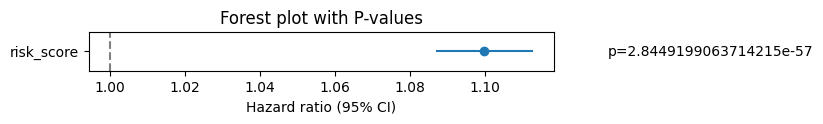

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Extract summary
summary = cph.summary.reset_index()
hr = summary['exp(coef)']
ci_lower = summary['exp(coef) lower 95%']
ci_upper = summary['exp(coef) upper 95%']
p_vals = summary['p']

# Plot
fig, ax = plt.subplots(figsize=(6, len(hr)*0.5))
y = np.arange(len(hr))
ax.errorbar(hr, y, xerr=[hr-ci_lower, ci_upper-hr], fmt='o')
for i, (p, name) in enumerate(zip(p_vals, summary['covariate'])):
    ax.text(ci_upper[i] + 0.02, i, f"p={p}", va='center')
ax.set_yticks(y)
ax.set_yticklabels(summary['covariate'])
ax.axvline(1, color='grey', linestyle='--')
ax.set_xlabel("Hazard ratio (95% CI)")
ax.set_title("Forest plot with P-values")
plt.tight_layout()
plt.show()


### TMA Corrolations

In [1]:
import pandas as pd
csv_clusters = pd.read_csv("/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/750K/adatas/Meso_TMA_he_complete_meta_filtered_leiden_2p0__fold4.csv")
metadata_cols = [col for col in csv_clusters.columns if col not in ['leiden_2.0', 'slides', 'samples', 'case', 'case_Id', 'col', 'cols', 'core_type', 'cores', 'donor_block', 'row', 'samples', 'slides','tiles', 'tmakey', 'tma', 'specimen_number', 'patterns', 'original_set', 'labels', 'type', 'Donor Block Number', 'indexes', 'os_event_data']]
slide_metadata = csv_clusters.groupby('samples')[metadata_cols].first() #because slides and samples are the same here
slide_metadata

,ATP5A Cytoplasmic H-Score,ATP5A Positive Tumour Area (%),DDX3X Cytoplasmic H-Score,DDX3X Positive Tumour Area (%),HB_score,SDHB Cytoplasmic H-Score,SDHB Positive Tumour Area (%),Stage,TMA Array Number,T_Stage,...,hist_subtype,ki67 Nuclear H-Score,ki67 Positive Tumour Area (%),os_event_ind,p-S6 Cytoplasmic H-Score,p-S6 Positive Tumour Area (%),recurrence,smoking_history,time_to_recurrence,wcc_score
samples,,,,,,,,,,,,,,,,,,,,,
MESO1_10-A,241,47,0,0,Normal,123,39,IIIA,TMA 1,T3,...,train,15,11,Dead,144,29,No Recurrence,Never smoked,1,Normal
MESO1_10-B,196,39,0,0,Low,62,22,II,TMA 1,T2,...,valid,13,8,Dead,186,39,No Recurrence,Ex-smoker,2,Normal
MESO1_10-C,203,50,0,0,Normal,57,25,IB,TMA 1,T3,...,train,172,90,Dead,95,21,No Recurrence,None,17,Normal
MESO1_10-D,200,46,0,0,Low,41,19,IB,TMA 1,T2,...,train,59,38,Dead,127,28,Recurrence,Never smoked,4,Normal
MESO1_10-E,231,38,0,0,Normal,112,28,IIIA,TMA 1,T3,...,train,10,6,Dead,34,7,No Recurrence,Ex-smoker,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MESO8_9-E,0,0,0,0,Normal,0,0,II,TMA 8,T2,...,train,0,0,Dead,0,0,No Recurrence,Never smoked,0,Normal
MESO8_9-G,0,0,0,0,Normal,0,0,IB,TMA 8,T2,...,test,0,0,Dead,0,0,No Recurrence,Current,1,High
MESO8_9-H,0,0,0,0,Normal,0,0,IIIA,TMA 8,T3,...,train,0,0,Dead,0,0,No Recurrence,Never smoked,1,Normal


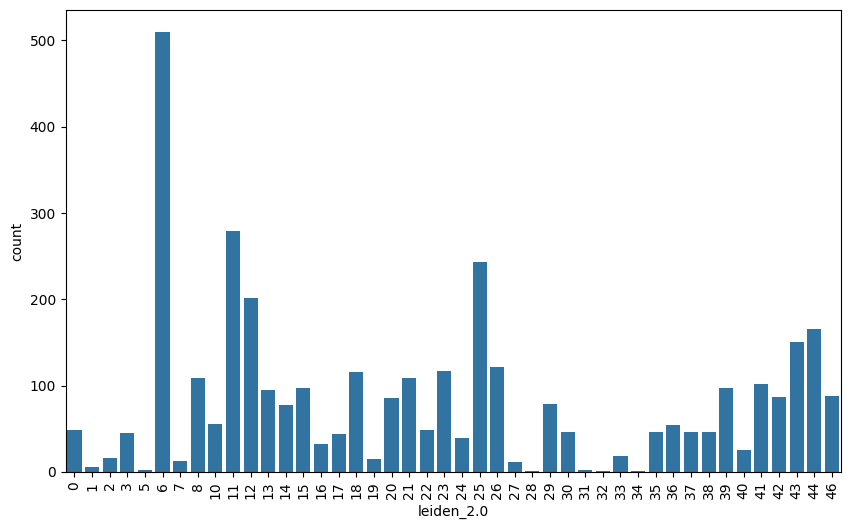

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# sns.set(style="whitegrid")
temp = csv_clusters['leiden_2.0'].value_counts().reset_index()
sns.barplot(x='leiden_2.0', y='count', data=temp)
plt.xticks(rotation=90);

In [3]:
cluster_counts = pd.crosstab(csv_clusters['slides'], csv_clusters['leiden_2.0'])
result_df = cluster_counts.join(slide_metadata)
result_df = result_df.reset_index()
result_df


,slides,0,1,2,3,5,6,7,8,10,...,hist_subtype,ki67 Nuclear H-Score,ki67 Positive Tumour Area (%),os_event_ind,p-S6 Cytoplasmic H-Score,p-S6 Positive Tumour Area (%),recurrence,smoking_history,time_to_recurrence,wcc_score
0,MESO1_10-A,0,0,0,0,0,1,0,0,0,...,train,15,11,Dead,144,29,No Recurrence,Never smoked,1,Normal
1,MESO1_10-B,0,0,0,0,0,0,0,0,0,...,valid,13,8,Dead,186,39,No Recurrence,Ex-smoker,2,Normal
2,MESO1_10-C,0,0,0,0,0,2,0,0,0,...,train,172,90,Dead,95,21,No Recurrence,None,17,Normal
3,MESO1_10-D,0,0,0,0,0,1,0,0,0,...,train,59,38,Dead,127,28,Recurrence,Never smoked,4,Normal
4,MESO1_10-E,0,0,0,0,0,0,0,1,1,...,train,10,6,Dead,34,7,No Recurrence,Ex-smoker,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,MESO8_9-E,0,0,0,0,0,0,0,0,0,...,train,0,0,Dead,0,0,No Recurrence,Never smoked,0,Normal
707,MESO8_9-G,0,0,0,0,0,0,0,0,0,...,test,0,0,Dead,0,0,No Recurrence,Current,1,High
708,MESO8_9-H,0,0,0,0,0,0,0,4,0,...,train,0,0,Dead,0,0,No Recurrence,Never smoked,1,Normal
709,MESO8_9-I,0,0,0,0,0,0,0,0,0,...,test,0,0,Dead,0,0,No Recurrence,Never smoked,0,Normal


In [4]:
cluster_cols = [col for col in result_df.columns if isinstance(col, int)]  # Assuming cluster columns are numeric
metadata_cols = [col for col in result_df.columns if col not in cluster_cols and col != 'slides']
metadata_cols

['ATP5A Cytoplasmic H-Score',
 'ATP5A Positive Tumour Area (%)',
 'DDX3X Cytoplasmic H-Score',
 'DDX3X Positive Tumour Area (%)',
 'HB_score',
 'SDHB Cytoplasmic H-Score',
 'SDHB Positive Tumour Area (%)',
 'Stage',
 'TMA Array Number',
 'T_Stage',
 'desmoplastic_component',
 'eif4A1 Cytoplasmic H-Score',
 'eif4A1 Positive Tumour Area (%)',
 'eif4A2 Cytoplasmic H-Score',
 'eif4A2 Positive Tumour Area (%)',
 'hist_subtype',
 'ki67 Nuclear H-Score',
 'ki67 Positive Tumour Area (%)',
 'os_event_ind',
 'p-S6 Cytoplasmic H-Score',
 'p-S6 Positive Tumour Area (%)',
 'recurrence',
 'smoking_history',
 'time_to_recurrence',
 'wcc_score']

Found 14 significant correlations after FDR correction


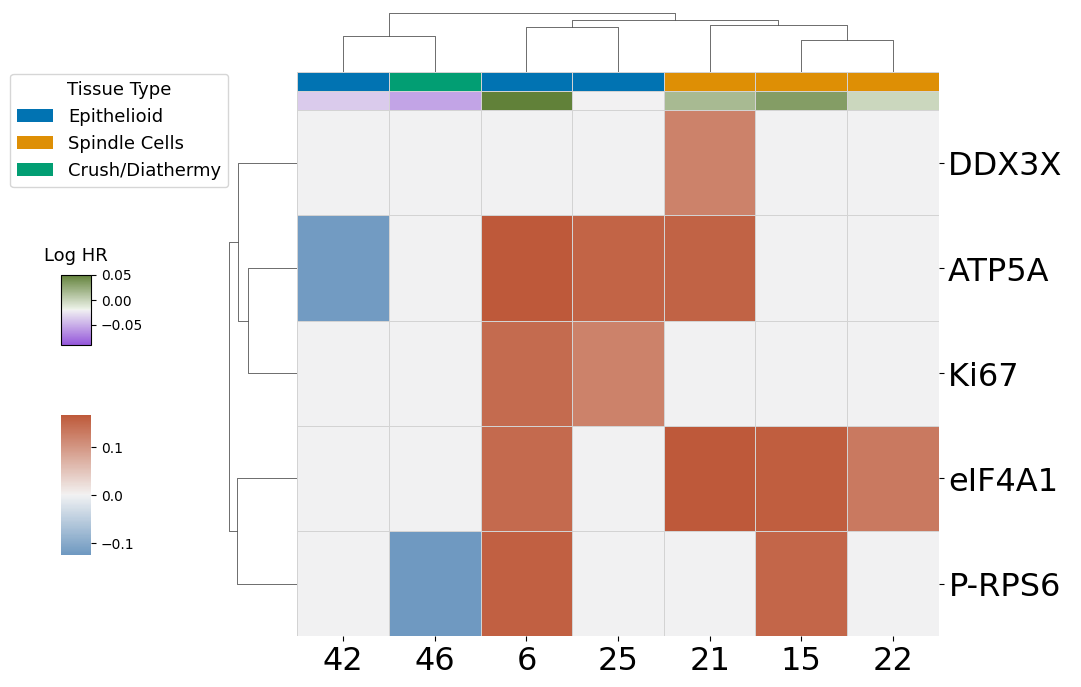

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from matplotlib.patches import Patch

def analyze_correlations(result_df, cluster_cols, metadata_cols, method='spearman'):
    results = []
    for meta_col in metadata_cols:
        if result_df[meta_col].dtype in [np.float64, np.int64]:  # Numeric columns only: the expression values
            for cluster in cluster_cols:
                if method == 'pearson':
                    corr, p_value = stats.pearsonr(result_df[cluster], result_df[meta_col])
                else:
                    corr, p_value = stats.spearmanr(result_df[cluster], result_df[meta_col])
                results.append({
                    'Marker': meta_col,
                    'HPC': cluster,
                    'Correlation': corr,
                    'P-value': p_value
                })
    

    corr_results = pd.DataFrame(results)
    if len(corr_results) > 0:
        _, corr_results['FDR_P_value'], _, _ = multipletests(
            corr_results['P-value'], alpha=0.05, method='fdr_bh')
    
    return corr_results



# Run the analysis
correlation_results = analyze_correlations(result_df, cluster_cols, metadata_cols, method='spearman')
col_lst = [col for col in correlation_results['Marker'].to_list() if 'Positive Tumour Area (%)' in col]
# col_lst = [col for col in correlation_results['Marker'].to_list() if 'H-Score' in col]

correlation_results = correlation_results[correlation_results['Marker'].isin(col_lst)]
significant_corrs = correlation_results[correlation_results['FDR_P_value'] < 0.05].sort_values('FDR_P_value')
print(f"Found {len(significant_corrs)} significant correlations after FDR correction")

if len(significant_corrs) > 0:
    pivot = significant_corrs.pivot(index='Marker', columns='HPC', values='Correlation')
    # display(pivot)
    col_color = pd.DataFrame(pivot.columns.tolist(), columns=['HPC'])
    col_color['tissue_type'] = ['Epithelioid','Spindle Cells', 'Spindle Cells', 'Spindle Cells', 'Epithelioid', 'Epithelioid', 'Crush/Diathermy' ] #manually for spearman
    # col_color['tissue_type'] = ['Epithelioid','Epithelioid', 'Sarcomatoid', 'Sarcomatoid', 'Sarcomatoid', 'Epithelioid' ] #manually for pearson
    col_color['hr_scores'] = [0.04175975566222409,0.05198583668484601, 0.027781003355872958, 0.042420492372507834,7.1313337996458956e-09, 6.705050824825024e-08, -0.008872036582806274] #manually for spearman
    nc = dict(zip(col_color['tissue_type'].unique(), sns.color_palette("colorblind")))
    hr = dict(zip(col_color['hr_scores'].to_list() + [-0.09, 0.05], sns.diverging_palette(110, -80, n=9)))
    col_color['color'] = col_color['tissue_type'].map(nc)
    col_color['hr_color'] = col_color['hr_scores'].map(hr)
    handles = [Patch(facecolor=nc[name]) for name in nc]
    

    # sns.heatmap(pivot.fillna(0), cmap=sns.diverging_palette(245,22, as_cmap=True))
    cl_map = sns.clustermap(pivot.fillna(0), cmap=sns.diverging_palette(245,22, as_cmap=True), center=0, figsize=(10,7), linecolor='lightgray', linewidths=0.5, cbar_pos=(-.15, .2, .03, .2), col_colors=[col_color['color'].tolist(),col_color['hr_color'].tolist()], dendrogram_ratio=(.1,.1))
    annot_df = pd.read_csv("/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/files/meso_annotations_750K.csv")
    # x_labels = [' (' + annot_df[annot_df['HPC']==x]['Summary'].values[0]+') '+str(x) for x in pivot.columns]
    y_labels = [x.get_text().replace('Positive Tumour Area (%)','').replace('eif4A1 ', 'eIF4A1').replace('p-S6 ', 'P-RPS6').replace('ki', 'Ki') for x in cl_map.ax_heatmap.get_yticklabels()]
    cl_map.ax_heatmap.set_yticklabels(y_labels, rotation=0, fontsize=23)
    cl_map.ax_heatmap.set_xticklabels(cl_map.ax_heatmap.get_xticklabels(), fontsize=23)
    cl_map.ax_heatmap.set_xlabel('')
    cl_map.ax_heatmap.set_ylabel('')
    cl_map.ax_heatmap.legend(handles, nc, bbox_to_anchor=(-0.21, .9), bbox_transform=plt.gcf().transFigure, loc='upper left', fontsize=13, title='Tissue Type', title_fontsize=13)


    # add another cbar for the hr colours
    m = plt.cm.ScalarMappable(cmap=sns.diverging_palette(-80, 110, as_cmap=True), norm=plt.Normalize(vmin=-0.09, vmax=0.05))
    cbar_ax = cl_map.fig.add_axes((-.15, .5, .03, .1))
    cbar_ax.set_title('Log HR', fontsize=13, pad=10)
    cbar2 = cl_map.fig.colorbar(m, cax=cbar_ax)

plt.savefig('temp_tmacorr.pdf',  bbox_inches='tight')



In [ ]:
marker = 'eif4A1 Positive Tumour Area (%)'
result_df.sort_values(by=[marker,6], ascending=[True, True]).head(135)[['slides', 6,25, marker]]

,slides,6,25,eif4A1 Positive Tumour Area (%)
7,MESO1_10-H,0,0,0
19,MESO1_11-J,0,0,0
100,MESO2_10-H,0,0,0
129,MESO2_15-D,0,0,0
151,MESO2_3-I,0,0,0
...,...,...,...,...
612,MESO8_10-C,3,1,0
640,MESO8_15-A,3,0,0
664,MESO8_3-F,3,0,0
338,MESO5_12-J,1,0,3


In [26]:
# (marker, max_slide, min_slide)
marker = 'DDX3X Positive Tumour Area (%)'

# finding the max and min slides for each marker
def get_max_min_slides(result_df, slides, cluster_cols):
    # max_slide = result_df.loc[result_df[marker].idxmax(), 'slides']
    # min_slide = result_df.loc[result_df[marker].idxmin(), 'slides']
    max_slide, min_slide = slides
    min_slide_clusters = result_df.loc[result_df['slides'] == min_slide, cluster_cols]
    min_HPCs = min_slide_clusters[min_slide_clusters > 0].dropna(axis=1, how='all')
    max_slide_clusters = result_df.loc[result_df['slides'] == max_slide, cluster_cols]
    max_HPCs = max_slide_clusters[max_slide_clusters > 0].dropna(axis=1, how='all')
    return (max_slide, min_slide), (max_HPCs, min_HPCs)

for marker, max_s, min_s in [('ATP5A','MESO3_10-B', 'MESO2_10-B' ),('DDX3X','MESO3_4-I', 'MESO1_10-A' ), ('eif4A1','MESO1_15-F', 'MESO2_15-I' ), ('ki67', 'MESO7_7-J', 'MESO5_12-G'), ('p-s6', 'MESO7_5-I', 'MESO2_15-J')]:
    print("---------------------------------------------------------------------------------")
    print(f"Marker: {marker.replace('Positive Tumour Area (%)', '')}")
    print("---------------------------------------------------------------------------------")
    max_min_slides, clusters = get_max_min_slides(result_df, (max_s, min_s), cluster_cols)
    print(f"Max: {max_min_slides[0]} \n {clusters[0]}\n")
    print(f"Min: {max_min_slides[1]} \n {clusters[1]}\n")
    print("---------------------------------------------------------------------------------")
    print("\n")
    

---------------------------------------------------------------------------------
Marker: ATP5A
---------------------------------------------------------------------------------
Max: MESO3_10-B 
      6  12  15  21  25
201  1   1   1   3   1

Min: MESO2_10-B 
     6  25  37
94  2   2   1

---------------------------------------------------------------------------------


---------------------------------------------------------------------------------
Marker: DDX3X
---------------------------------------------------------------------------------
Max: MESO3_4-I 
      6  15  21  30  43
283  1   1   1   1   2

Min: MESO1_10-A 
    6  11  43
0  1   2   2

---------------------------------------------------------------------------------


---------------------------------------------------------------------------------
Marker: eif4A1
---------------------------------------------------------------------------------
Max: MESO1_15-F 
     11  26  46
44   1   1   1

Min: MESO2_15-I 
      44
1

Loading representations: /nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning//results/BarlowTwins_3/Meso_TMA/h224_w224_n3_zdim128/hdf5_Meso_TMA_he_complete.h5
Keys: <KeysViewHDF5 ['hist_subtype', 'img_h_latent', 'img_z_latent', 'indexes', 'labels', 'original_set', 'patterns', 'samples', 'slides', 'tiles']>
Meso_TMA
/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/datasets/Meso_TMA/he/patches_h224_w224/hdf5_Meso_TMA_he_train.h5
		Whole Slide Image Resolution MESO2_7-D: (672, 672)


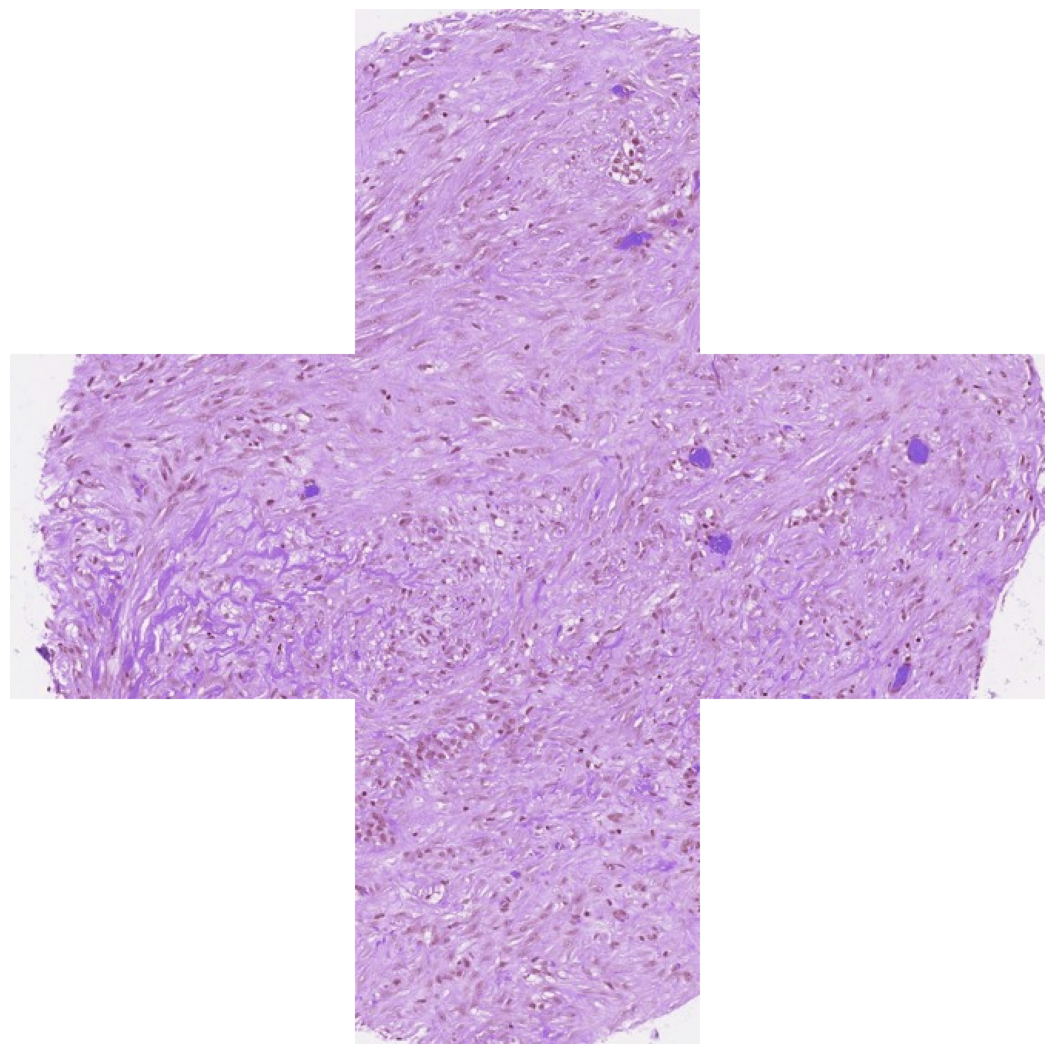

In [113]:
main_path = '/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/'
dataset = 'Meso_TMA'
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete.h5'.format(main_path, dataset, dataset)
frame, dims, rest = representations_to_frame(h5_complete_path, meta_field='Meso_type', rep_key='z_latent')

data = Data(dataset=dataset, marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=main_path, load=True)
data_dicts = dict()

data_dicts['train'] = data.training.images
data_dicts['valid'] = data.validation.images
data_dicts['test']  = data.test.images

# Get tile information.
def get_x_y(tile_info):
    if '.' in str(tile_info):
        string = tile_info.split('.')[0]
    else:
        string = str(tile_info)
    x, y   = string.split('_')
    return int(x),int(y)
    
def get_wsi_arrays(frame, slide, img_size, downsample, img_dicts):
    slide_indices  = frame[frame[matching_field]==slide].indexes.values.tolist()
    slide_tiles    = frame[frame[matching_field]==slide].tiles.values.tolist()
    slide_sets     = frame[frame[matching_field]==slide].original_set.values.tolist()
    # clr_plt = sns.color_palette("coolwarm", as_cmap=True)

    # color_map = clr_plt(attention_scores)

    y,x = get_x_y(slide_tiles[0])
    x_min = x
    x_max = x
    y_min = y
    y_max = y
    for i in slide_tiles:
        y_i, x_i  = get_x_y(i)
        x_min = min(x_min, x_i)
        y_min = min(y_min, y_i)
        x_max = max(x_max, x_i)
        y_max = max(y_max, y_i)
    x_max += 1
    y_max += 1

    wsi_x = int(x_max*img_size//downsample)
    wsi_y = int(y_max*img_size//downsample)

    # Original 5x.
    wsi   = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    # wsi_c = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    print('\t\tWhole Slide Image Resolution %s: (%s, %s)' % (slide, wsi_x, wsi_y))

    for index, tile, original_set in zip(slide_indices, slide_tiles, slide_sets):
        y_i, x_i  = get_x_y(tile)
        x_i *= img_size//downsample
        y_i *= img_size//downsample
        tile_img = img_dicts[original_set][int(index)]
        tile_img = np.array(resize(tile_img, (tile_img.shape[0]//downsample, tile_img.shape[1]//downsample), anti_aliasing=True), dtype=float)
        tile_img = (tile_img*255).astype(np.uint8)     
        
        mask  = np.ones((img_size//downsample,img_size//downsample))

        wsi[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :]   = tile_img
        # wsi_c[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :] = apply_mask(tile_img, mask, color, alpha=0.5)

    return wsi

case_Id = 'MESO2_7-D'
matching_field = 'slides'

# Get the attention scores for the specific case
temp = frame[frame['slides']==case_Id].iloc[:,0:128].values
temp_tnsr = torch.from_numpy(temp).resize(temp.shape[0],temp.shape[1])


wsi = get_wsi_arrays(frame, case_Id, img_size=224, downsample=1, img_dicts=data_dicts)

for num, wsi_ in enumerate([wsi]):
    dpi = 50
    height, width, _ = wsi_.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(1, 1, 1) 
    ax.imshow(wsi_/255.)
    ax.axis('off')
    plt.show(fig)
    # plt.savefig(f'{figure_path}/trans_meso/{wsi_name}_{case_Id}.png', bbox_inches='tight', dpi=dpi)
    # plt.savefig("{}/figures/{}_{}.png".format(folder_path, case_Id,num), bbox_inches='tight', dpi=dpi)
    plt.close(fig)


Regularisation and Domain Generalisation for Subtyping

In [1]:
from matplotlib        import collections             as matcoll
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm
from matplotlib.pyplot import rc_context
from scipy.cluster     import hierarchy
from adjustText        import adjust_text
from sklearn.metrics import *

from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_curve

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import math
import glob
import h5py
import sys
import os

main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()

figure_path = main_path + '/workflow/figures/subtype/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path, exist_ok=True)
import warnings
warnings.filterwarnings("ignore")

import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
sys.path.append(main_path)
from models.evaluation.folds import load_existing_split
from models.clustering.correlations import *
from models.clustering.data_processing import *
from data_manipulation.utils import store_data
from IPython.display import clear_output
clear_output()

In [2]:
# Resolution and fold for the tile clustering and slide representations.
resolution     = 2.0
fold_number    = 4
groupby        = 'leiden_%s' % resolution

# Folder run.
dataset     = 'Meso'
additional_dataset = 'TCGA_MESO'
meta_folder     = '750K'
# meta_folder     = 'meso_overal_survival_nn400'

matching_field  = 'slides'
meta_field      = 'Meso_type'


# Penalties for Cox regression and flag for usage.
use_cox        = False
alpha          = 5.0

# Pickle files.
folds_pickle = '{}/files/pkl_{}_he_test_train_slides.pkl'.format(main_path, dataset)

# Tile representation files.
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, additional_dataset, additional_dataset)

# adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, '750K', groupby, fold_number)




In [3]:

def roc_curve_plot(pred, labels, title, label):
	sns.set(style='white', font_scale=1)
	fpr, tpr, thresholds = roc_curve(labels, pred)
	fig, ax = plt.subplots(figsize=(4.5,4.5))
	ax.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
	ax.set_xlim([0.0, 1.0])
	ax.set_ylim([0.0, 1.0])
	ax.set_xlabel('False Positive Rate')
	ax.set_ylabel('True Positive Rate')
	ax.set_title(title)
	# set font size
	plt.rcParams.update({'font.size': 12})



	# Plot ROC curve.
	ax.plot(fpr, tpr, label=label)
	plt.legend(loc="lower right")
	# plt.show()
	return ax

In [4]:
import statsmodels.api as sm


# Get AUC performance.
def get_scores(model, data, label, mode):
	threshold = 0.3
	train, valid, test, additional = data
	train_data, train_labels = train
	if valid is not None:
		valid_data, valid_labels = valid
	test_data,  test_labels  = test
	if additional is not None:
		additional_data, additional_labels = additional

	# Predictions.
	train_pred = model.predict(exog=train_data)
	if valid is not None:
		valid_pred = model.predict(exog=valid_data)
	test_pred  = model.predict(exog=test_data)
	if additional is not None:
		additional_pred = model.predict(exog=additional_data)
	tn, fp, fn, tp = confusion_matrix(train_labels[:,label], (train_pred > threshold)*1.0).ravel()
	if mode == 'AUC': 					train_auc = roc_auc_score(y_true=list(train_labels[:,label]), y_score=list(train_pred))
	elif mode == 'Average Precision': 	train_auc = average_precision_score(y_true=list(train_labels[:,label]), y_score=list(train_pred))
	elif mode == 'Accuracy': 			train_auc = accuracy_score(y_true=list(train_labels[:,label]), y_pred=(train_pred > threshold)*1.0)
	elif mode == 'F1 Score': 			train_auc = f1_score(y_true=list(train_labels[:,label]), y_pred=(train_pred > threshold)*1.0)
	elif mode == 'Recall Score': 		train_auc = recall_score(y_true=list(train_labels[:,label]), y_pred=(train_pred > threshold)*1.0)
	elif mode == 'Precision Score': 	train_auc = precision_score(y_true=list(train_labels[:,label]), y_pred=(train_pred > threshold)*1.0)
	elif mode == 'Sensitivity': 		train_auc = tp / (tp+fn)
	elif mode == 'Specificity': 		train_auc  = tn / (tn+fp)
	elif mode == 'Balanced Accuracy': 	train_auc = ((tp / (tp+fn)) + (tn / (tn+fp)))/2
	else: raise ValueError('Mode not recognized.')	
	

	aucs = [train_auc]
	# aucs = []
	valid_auc = None
	if valid is not None:
		tn, fp, fn, tp = confusion_matrix(valid_labels[:,label], (valid_pred > threshold)*1.0).ravel()
		# valid_auc = roc_auc_score(y_true=list(valid_labels[:,label]), y_score=list(valid_pred))
		if mode == 'AUC': 					valid_auc = roc_auc_score(y_true=list(valid_labels[:,label]), y_score=list(valid_pred))
		elif mode == 'Average Precision': 	valid_auc = average_precision_score(y_true=list(valid_labels[:,label]), y_score=list(valid_pred))
		elif mode == 'Accuracy': 			valid_auc = accuracy_score(y_true=list(valid_labels[:,label]), y_pred=(valid_pred > threshold)*1.0)
		elif mode == 'F1 Score': 			valid_auc = f1_score(y_true=list(valid_labels[:,label]), y_pred=(valid_pred > threshold)*1.0)
		elif mode == 'Recall Score': 		valid_auc = recall_score(y_true=list(valid_labels[:,label]), y_pred=(valid_pred > threshold)*1.0)
		elif mode == 'Precision Score': 	valid_auc = precision_score(y_true=list(valid_labels[:,label]), y_pred=(valid_pred > threshold)*1.0)
		elif mode == 'Sensitivity': 		valid_auc = tp / (tp+fn)
		elif mode == 'Specificity': 		valid_auc  = tn / (tn+fp)
		elif mode == 'Balanced Accuracy': 	valid_auc = ((tp / (tp+fn)) + (tn / (tn+fp)))/2
		else: raise ValueError('Mode not recognized.')
		aucs.append(valid_auc)
	tn, fp, fn, tp = confusion_matrix(test_labels[:,label], (test_pred > threshold)*1.0).ravel()
	# test_auc  = roc_auc_score(y_true=list(test_labels[:,label]),  y_score=list(test_pred))
	if mode == 'AUC': 					test_auc = roc_auc_score(y_true=list(test_labels[:,label]), y_score=list(test_pred))
	elif mode == 'Average Precision': 	test_auc = average_precision_score(y_true=list(test_labels[:,label]), y_score=list(test_pred))
	elif mode == 'Accuracy': 			test_auc = accuracy_score(y_true=list(test_labels[:,label]), y_pred=(test_pred > threshold)*1.0)
	elif mode == 'F1 Score': 			test_auc = f1_score(y_true=list(test_labels[:,label]), y_pred=(test_pred > threshold)*1.0)
	elif mode == 'Recall Score': 		test_auc = recall_score(y_true=list(test_labels[:,label]), y_pred=(test_pred > threshold)*1.0)
	elif mode == 'Precision Score': 	test_auc = precision_score(y_true=list(test_labels[:,label]), y_pred=(test_pred > threshold)*1.0)
	elif mode == 'Sensitivity': 		test_auc = tp / (tp+fn)
	elif mode == 'Specificity': 		test_auc  = tn / (tn+fp)
	elif mode == 'Balanced Accuracy': 	test_auc = ((tp / (tp+fn)) + (tn / (tn+fp)))/2
	else: raise ValueError('Mode not recognized.')

	aucs.append(test_auc)
	additional_auc = None
	if additional is not None:
		tn, fp, fn, tp = confusion_matrix(additional_labels[:,label], (additional_pred > threshold)*1.0).ravel()
		additional_pred = model.predict(exog=additional_data)
		if mode == 'AUC': 					additional_auc = roc_auc_score(y_true=list(additional_labels[:,label]), y_score=list(additional_pred))
		elif mode == 'Average Precision': 	additional_auc = average_precision_score(y_true=list(additional_labels[:,label]), y_score=list(additional_pred))
		elif mode == 'Accuracy': 			additional_auc = accuracy_score(y_true=list(additional_labels[:,label]), y_pred=(additional_pred > threshold)*1.0)
		elif mode == 'F1 Score': 			additional_auc = f1_score(y_true=list(additional_labels[:,label]), y_pred=(additional_pred > threshold)*1.0)
		elif mode == 'Recall Score': 		additional_auc = recall_score(y_true=list(additional_labels[:,label]), y_pred=(additional_pred > threshold)*1.0)
		elif mode == 'Precision Score': 	additional_auc = precision_score(y_true=list(additional_labels[:,label]), y_pred=(additional_pred > threshold)*1.0)
		elif mode == 'Sensitivity': 		additional_auc = tp / (tp+fn)
		elif mode == 'Specificity': 		additional_auc  = tn / (tn+fp)
		elif mode == 'Balanced Accuracy': 	additional_auc = ((tp / (tp+fn)) + (tn / (tn+fp)))/2
		else: raise ValueError('Mode not recognized.')
		aucs.append(additional_auc)
	return aucs

# Include coefficients into clusters dataframe.
def include_coefficients(model, frame_clusters_orig, features, label, groupby):
	frame_clusters = frame_clusters_orig.copy(True)

	# Include model coef.
	results_summary = model.summary()
	results_as_html = results_summary.tables[1].as_html()
	results_df      = pd.read_html(results_as_html, header=0, index_col=0)[0]

	for column in ['coef', 'P>|z|','[0.025','0.975]']:
		frame_clusters['%s_%s' % (column, label)] = [np.inf]*frame_clusters.shape[0]
		for i, cluster_id in enumerate(features):
			frame_clusters.loc[frame_clusters[groupby]==int(cluster_id), '%s_%s' % (column, label)] = float(results_df.loc[int(i), column])
	return frame_clusters


# Fit logistic regression and check performance.
def classification_performance_stats(data, leiden_clusters, frame_clusters, features, groupby, alpha, modes=['auc', 'ap']):
	train, valid, test, additional = data
	train_data, train_labels = train

	# Train classifier
	labels = np.unique(np.argmax(train_labels, axis=1)).tolist()
	if len(labels) == 2:
		labels.remove(0)

	# One-vs-rest for Logistic Regression.
	num_sets = len([1 for set in data if set is not None])
	shape_aucs = (len(labels), len(modes), num_sets)
	total_aucs = np.zeros(shape_aucs)
	cms        = dict()
	for label in labels:
		model                  = sm.Logit(endog=train_labels[:,label], exog=train_data).fit_regularized(method='l1_cvxopt_cp',alpha=alpha, maxiter=1000, disp=False)
		# total_aucs[label-1,:]  = get_avg_precision(model, data, label)
		# total_aucs[label-1,:]  = get_aucs(model, data, label)
		print("\n---------------------------------------------------------------------------------\n")
		print(model.summary())
		lr_statistic = model.llr
		df_model = model.df_model
		p_value = model.llr_pvalue
		from decimal import Decimal
		print(f"X2({df_model}) = {lr_statistic:.4f}", 'P: %.2E ' % (Decimal(p_value)))
		for mode in modes:
			total_aucs[label-1, modes.index(mode), :]  = get_scores(model, data, label, mode)


		# total_aucs[label-1,:, :]  = get_scores_simple(train_labels[:,label], model.predict(exog=train_data))
			
		# Include information in Clusters DataFrame.
		frame_clusters = include_coefficients(model, frame_clusters, features, label, groupby)

		# Confusion matrices.
		# label_cms = get_confusion_matrix(model, data, label)
		# cms[label] = label_cms

	aucs = total_aucs.mean(axis=0).tolist()
	return frame_clusters, aucs, None, model


Subsampling: undersampling ___________________________________________

---------------------------------------------------------------------------------

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1972
Model:                          Logit   Df Residuals:                     1933
Method:                           MLE   Df Model:                           38
Date:                Thu, 31 Jul 2025   Pseudo R-squ.:                  0.4942
Time:                        11:34:38   Log-Likelihood:                -665.70
converged:                       True   LL-Null:                       -1316.0
Covariance Type:            nonrobust   LLR p-value:                2.606e-248
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2354      0.074     -3.199      0.001 

,Leiden Resolution,Train AUC,Test AUC,Additional AUC,Train Recall Score,Test Recall Score,Additional Recall Score,Train Precision Score,Test Precision Score,Additional Precision Score,...,Additional F1 Score,Train Accuracy,Test Accuracy,Additional Accuracy,Train Sensitivity,Test Sensitivity,Additional Sensitivity,Train Specificity,Test Specificity,Additional Specificity
0,2.0,0.91 ± 0.01,0.88 ± 0.04,0.8 ± 0.03,0.85 ± 0.03,0.81 ± 0.1,0.63 ± 0.06,0.68 ± 0.03,0.61 ± 0.21,0.69 ± 0.05,...,0.66 ± 0.04,0.82 ± 0.02,0.77 ± 0.07,0.72 ± 0.02,0.85 ± 0.03,0.81 ± 0.1,0.63 ± 0.06,0.81 ± 0.03,0.77 ± 0.09,0.79 ± 0.04


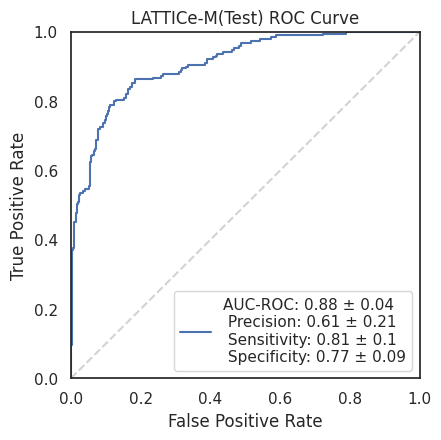

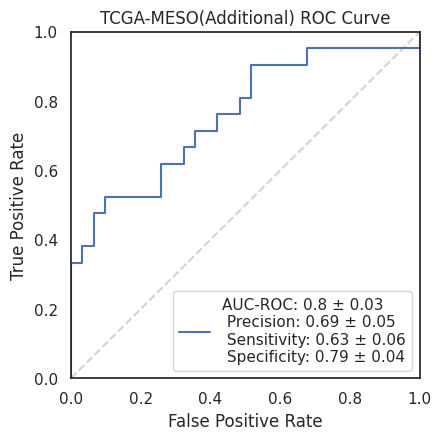

In [ ]:
folds = load_existing_split(folds_pickle)
subtype_csvs_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/subtype_csvs'.format(main_path, dataset, meta_folder)
frame_clusters = dict()
models = dict()
subsampling = True
type_composition = 'clr'
score_modes = ['AUC', 'Recall Score', 'Precision Score', 'F1 Score', 'Accuracy', 'Sensitivity', 'Specificity']
# score_modes = ['Precision Score', 'Sensitivity', 'Specificity']
# resolutions = ['2p0', '0p7', '1p0', '1p5', '2p5', '3p0', '4p0', '5p0', '7p0', '9p0']
# resolutions = ['2p0', '4p0', '7p0', '9p0']
resolutions = ['2p0']

# for subsampling in [None,'undersampling','oversampling']:
for subsampling in ['undersampling']:
    print('Subsampling:', subsampling, '___________________________________________')
    all_aucs = []

    for resolution in resolutions:
        frame_clusters[resolution] = dict()
        models[resolution] = dict()
        for fold in range(5):
            # fold = 4
            df_all = pd.read_csv('{}/{}_{}_leiden_{}_fold{}.csv'.format(subtype_csvs_path, dataset, type_composition, resolution, fold), index_col=0)
            df_all.drop('Meso_type_x', axis=1, inplace=True)
            df_all.rename(columns={'Meso_type_y': 'Meso_type'}, inplace=True)

            train_samples = folds[fold][0]
            val_samples = folds[fold][1]
            test_samples = folds[fold][2]
            train_df = df_all[df_all['samples'].isin(train_samples)]
            test_df = df_all[df_all['samples'].isin(test_samples)]

            additional_df = pd.read_csv('{}/{}_{}_leiden_{}_fold{}_additional.csv'.format(subtype_csvs_path, additional_dataset, type_composition, resolution, fold), index_col=0)
            additional_df.drop('Meso_type_x', axis=1, inplace=True)
            additional_df.rename(columns={'Meso_type_y': 'Meso_type'}, inplace=True)

            # Include features that are not the regular leiden clusters.
            frame_cluster = pd.read_csv('{}/HPC_frames/{}_{}_leiden_{}_fold{}_hpc_purity.csv'.format(subtype_csvs_path, dataset, type_composition, resolution, fold), index_col=0)



            features = [x for x in df_all.columns.tolist() if x.isdigit()]
            leiden_clusters = [int(x) for x in features]
            train_labels = np.array(train_df[['Meso_type']].values.astype(int).tolist())
            train_labels = OneHotEncoder().fit_transform(train_labels.reshape(-1,1)).toarray()
            test_labels = np.array(test_df[['Meso_type']].values.astype(int).tolist())
            test_labels = OneHotEncoder().fit_transform(test_labels.reshape(-1,1)).toarray()
            additional_labels = np.array(additional_df[['Meso_type']].values.astype(int).tolist())
            additional_labels = OneHotEncoder().fit_transform(additional_labels.reshape(-1,1)).toarray()

            data = [[train_df[features], train_labels], None, [test_df[features], test_labels], [additional_df[features], additional_labels]]
            if subsampling is not None:
                # Subsampling the imbalance data
                from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE # SMOTE
                from imblearn.combine import SMOTEENN, SMOTETomek # SMOTETomek
                from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler
                if subsampling == 'undersampling':
                    smt = EditedNearestNeighbours(sampling_strategy='majority') #undersampling
                elif subsampling == 'oversampling':
                    smt = SMOTETomek(random_state=42) #oversampling
                else:
                    smt = None
                    raise ValueError('Subsampling method not recognized.')
                
                for df in data:
                    if df is not None:
                        df[0], df[1] = smt.fit_resample(df[0], df[1])
                        df[1] = OneHotEncoder().fit_transform(df[1].reshape(-1, 1)).toarray()
            
            frame_cluster, aucs, cms, lr_model = classification_performance_stats(data, leiden_clusters, frame_cluster, features, 'leiden_{}'.format(resolution.replace('p','.')), alpha=5, modes=score_modes)


            # if fold == 0: #draw the roc curve for additional data and test data
            if fold == 4:
                test_labels = data[2][1][:,1]
                test_pred = lr_model.predict(exog=data[2][0])

                additional_labels = data[3][1][:,1]
                additional_pred = lr_model.predict(exog=data[3][0])
                
            frame_clusters[resolution][fold] = frame_cluster
            models[resolution][fold] = lr_model

            # print('\t\t\tFold %s %-3s features Train/Test/Additional Score:' % (fold, len(features)), np.round(aucs,2))

            # Report forest plots and confusion matrices for logistic regression.
            # from models.visualization.forest_plots import report_forest_plot_lr
            alpha_path = os.path.join(subtype_csvs_path.split('/subtype_csvs')[0], 'alpha_{}'.format(alpha))
            if not os.path.exists(alpha_path):
                os.makedirs(alpha_path)
            # report_forest_plot_lr(meta_field, frame_cluster, directory=alpha_path, file_name='%s_fold%s_clusters.csv' % (resolution, fold))
            mode_auc = []
            for auc in aucs: mode_auc += auc
            all_aucs.append([resolution.replace('p','.'), fold] + mode_auc)

    # Save to CSV.
    mode_sets = []
    for mode in score_modes: 
        mode_sets += ['Train {}'.format(mode), 'Test {}'.format(mode), 'Additional {}'.format(mode)]

    columns = ['Leiden Resolution', 'Fold']+ mode_sets
    results_df = pd.DataFrame(all_aucs, columns=columns)
    print('length of the datset:', len(test_labels))
    print('length of the additional dataset:', len(additional_labels))

    df_mean = results_df.groupby(['Leiden Resolution']).mean().drop('Fold', axis=1).apply(lambda x: np.round(x,2))
    df_std = results_df.groupby(['Leiden Resolution']).std().drop('Fold', axis=1).apply(lambda x: np.round(x,2))
    temp = (df_mean.astype(str) + ' ± ' + df_std.astype(str)).reset_index()


    # label_test = 'AUC-ROC:86.9 ± 0.0\nPrecision:62.3 ± 0.2  \nSensitivity:80.6 ± 0.1 \nSpecificity:72.9 ± 0.1'
    label_test = 'AUC-ROC: ' +str(temp["Test AUC"][temp["Leiden Resolution"]==resolution.replace('p','.')].values[0]) + "\n Precision: " + str(temp["Test Precision Score"][temp["Leiden Resolution"]==resolution.replace('p','.')].values[0]) + "\n Sensitivity: " + str(temp["Test Sensitivity"][temp["Leiden Resolution"]==resolution.replace('p','.')].values[0]) + "\n Specificity: " + str(temp["Test Specificity"][temp["Leiden Resolution"]==resolution.replace('p','.')].values[0])

    label_additional = 'AUC-ROC: ' +str(temp["Additional AUC"][temp["Leiden Resolution"]==resolution.replace('p','.')].values[0]) + "\n Precision: " + str(temp["Additional Precision Score"][temp["Leiden Resolution"]==resolution.replace('p','.')].values[0]) + "\n Sensitivity: " + str(temp["Additional Sensitivity"][temp["Leiden Resolution"]==resolution.replace('p','.')].values[0] )+ "\n Specificity: " + str(temp["Additional Specificity"][temp["Leiden Resolution"]==resolution.replace('p','.')].values[0])
    print('test labels:\n', label_test)
    print('additional labels:\n', label_additional)
    roc_curve_plot(test_pred, test_labels, 'LATTICe-M(Test) ROC Curve', label=label_test)
    plt.savefig('temp1.pdf',  bbox_inches='tight')


    # label_additional = 'AUC-ROC:76.5 ± 0.0\nPrecision:62.1 ± 0.1  \nSensitivity:61.9 ± 0.1\nSpecificity:75.3 ± 0.1'
    roc_curve_plot(additional_pred, additional_labels, 'TCGA-MESO(Additional) ROC Curve', label=label_additional)
    


    display(temp)
    # temp.to_csv("temp.csv")
        
